![](https://www.santander.co.uk/themes/custom/santander_web18/logo.svg)

[image-source](https://www.santander.co.uk/themes/custom/santander_web18/logo.svg)



## Main outline

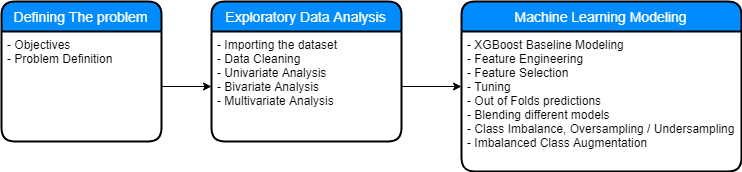

## Table of Contents

- [Problem Definition and Objectives](#intro)
- [Exploratory Data Analysis](#EDA)
- [Machine Learning Modeling](#ML)
    - [Feature Engineering](#FE)
    - [Baseline Modeling](#base)
    - [Feature Selection](#FS)
    - [Bayesian Optimization](#Bayes)
    - [Tuned Model Training](#tuned)
- [Conclusion](#conclusion)

## Problem Definition and Objectives
<a id="intro"></a>

At Santander our mission is to help people and businesses prosper. We are always looking for ways to help our customers understand their financial health and identify which products and services might help them achieve their monetary goals.

Santander is continually challenging its machine learning algorithms, working with the global data science community to make sure we can more accurately identify new ways to solve our most common challenge, binary classification problems such as: is a customer satisfied? Will a customer buy this product? Can a customer pay this loan?

In this challenge, Kagglers are invited to help Santander identify which customers will make a specific transaction in the future, irrespective of the amount of money transacted. The data provided for this competition has the same structure as the real data we have available to solve this problem.

Submissions are evaluated on area under the ROC curve between the predicted probability and the observed target.

You are provided with an anonymized dataset containing numeric feature variables, the binary target column, and a string ID_code column.

The task is to predict the value of target column in the test set.

## Exploratory Data Analysis
<a id="EDA"></a>

![](http://blog.k2analytics.co.in/wp-content/uploads/2016/12/Exploratory_Data_Analysis.png)

[image-source](http://blog.k2analytics.co.in/wp-content/uploads/2016/12/Exploratory_Data_Analysis.png)

### Importing the dataset

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

import gc

# Any results you write to the current directory are saved as output.

['train.csv', 'sample_submission.csv', 'test.csv']


In [2]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

In [3]:
train.shape, test.shape

((200000, 202), (200000, 201))

In [4]:
train.columns

Index(['ID_code', 'target', 'var_0', 'var_1', 'var_2', 'var_3', 'var_4',
       'var_5', 'var_6', 'var_7',
       ...
       'var_190', 'var_191', 'var_192', 'var_193', 'var_194', 'var_195',
       'var_196', 'var_197', 'var_198', 'var_199'],
      dtype='object', length=202)

At first glance we have many uncharacterized numerical features, their names has the prefix "var_" and they are 200 in numbers. There are so many variables that some histograms will shed light to their numerical appearance.

In [5]:
train.target.value_counts()

0    179902
1     20098
Name: target, dtype: int64

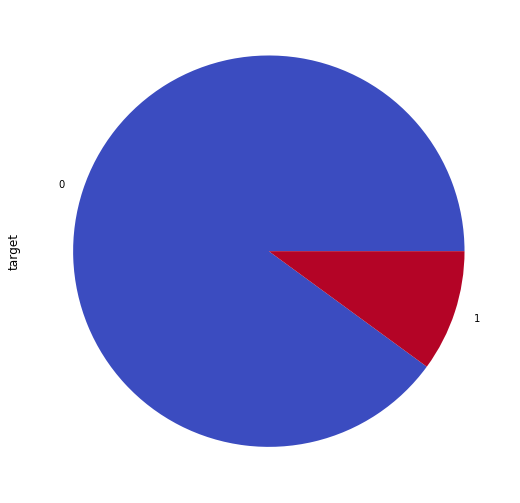

In [6]:
train['target'].value_counts().plot(kind="pie", figsize=(12,9), colormap="coolwarm")

Here we have a typical imbalanced dataset.

#### check for missing data

In [7]:
train.isna().sum().sum()

0

In [8]:
test.isna().sum().sum()

0

We have no NA values which is very nice!!

#### Splitting the numerical features

In [9]:
gc.collect();
train.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.100490,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,7.567236,0.394340,-3.245596,14.023978,8.530232,7.537606,14.573126,9.333264,-5.696731,15.244013,12.438567,13.290894,17.257883,4.305430,3.019540,10.584400,13.667496,-4.055133,-1.137908,5.532980,5.053874,-7.687740,10.393046,-0.512886,14.774147,11.434250,3.842499,2.187230,5.868899,10.642131,...,24.259300,5.633293,5.362896,11.002170,-2.871906,19.315753,2.963335,-4.151155,4.937124,5.636008,-0.004962,-0.831777,19.817094,-0.677967,20.210677,11.640613,-2.799585,11.882933,-1.014064,2.591444,-2.741666,10.085518,0.719109,8.769088,12.756676,-3.983261,8.970274,-10.335043,15.377174,0.746072,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,0.300653,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,1.235070,5.500793,5.970253,0.190059,4.639536,2.247908,0.411711,2.557421,6.712612,7.851370,7.996694,5.876254,8.196564,2.847958,0.526893,3.777245,0.285535,5.922210,1.523714,0.783367,2.615942,7.965198,2.159891,2.587830,4.322325,0.541614,5.179559,3.119978,2.249730,4.278903,...,10.880263,0.217938,1.419612,5.262056,5.457784,5.024182,0.369684,7.798020,3.105986,0.369437,4.424621,5.378008,8.674171,5.966674,7.136427,2.892167,7.513939,2.628895,8.579810,2.798956,5.261243,1.371862,8.963434,4.474924,9.318280,4.725167,3.189759,11.574708,3.944604,0.976348,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,0.000000,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,3.970500,-20.731300,-26.095000,13.434600,-6.011100,1.013300,13.076900,0.635100,-33.380200,-10.664200,-12.402500,-5.432200,-10.089000,-5.322500,1.209800,-0.678400,12.720000,-24.243100,-6.166800,2.089600,-4.787200,-34.798400,2.140600,-8.986100,1.508500,9.816900,-16.513600,-8.095100,-1.183400,-6.337100,...,-7.452200,4.852600,0.623100,-6.531700,-19.997700,3.816700,1.851200,-35.969500,-5.250200,4.258800,-14.506000,-22.479300,-11.453300,-22.748700,-2.995300,3.241500,-29.116500,4.952100,-29.273400,-7.856100,-22.037400,5.416500,-26.001100,-4.808200,-18.489700,-22.583300,-3.022300,-47.753600,4.412300,-2.554300,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.26

In [10]:
numerical_features = train.columns[2:]

Distributions columns


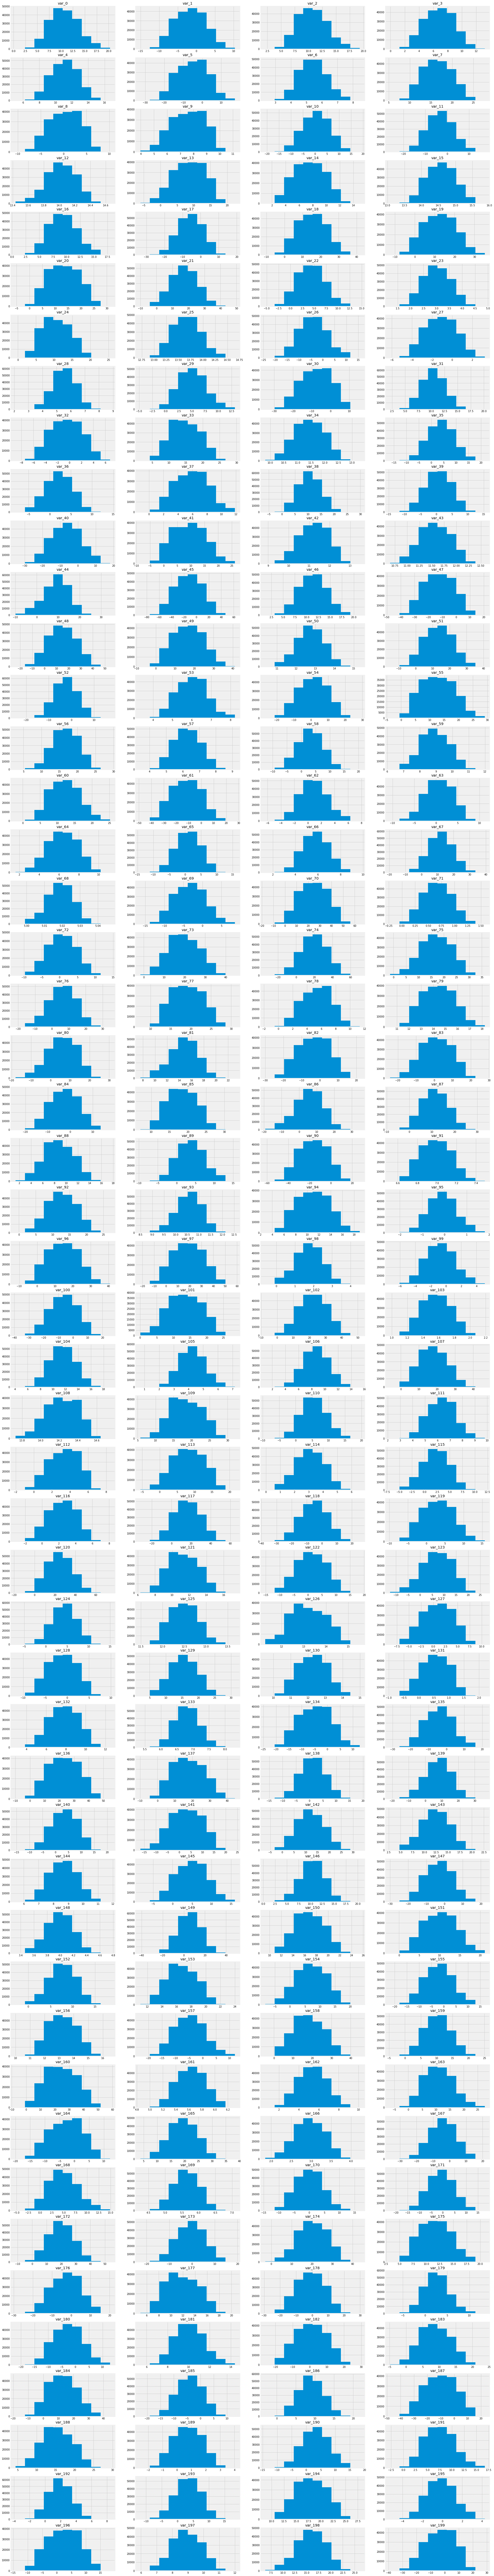

In [11]:
print('Distributions columns')
plt.figure(figsize=(30, 185))
for i, col in enumerate(numerical_features):
    plt.subplot(50, 4, i + 1)
    plt.hist(train[col]) 
    plt.title(col)
gc.collect();

Almost all features shows a normal distribution shape. Lets see the distributions for for all numerical features per each class.

Distributions columns


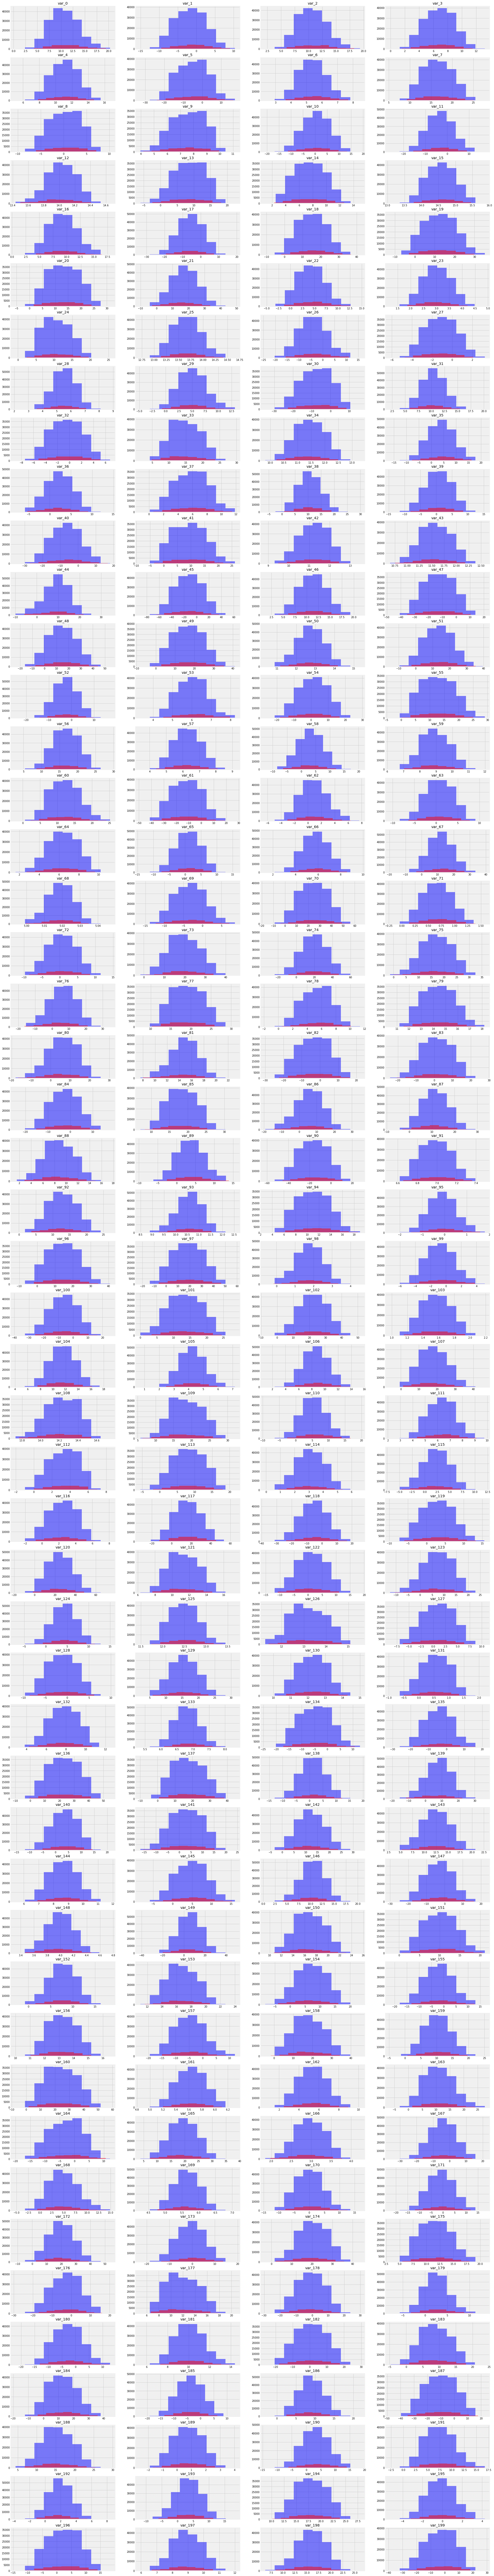

In [12]:
print('Distributions columns')
plt.figure(figsize=(30, 185))
for i, col in enumerate(numerical_features):
    plt.subplot(50, 4, i + 1)
    plt.hist(train[train["target"] == 0][col], alpha=0.5, label='0', color='b')
    plt.hist(train[train["target"] == 1][col], alpha=0.5, label='1', color='r')    
    plt.title(col)
gc.collect();

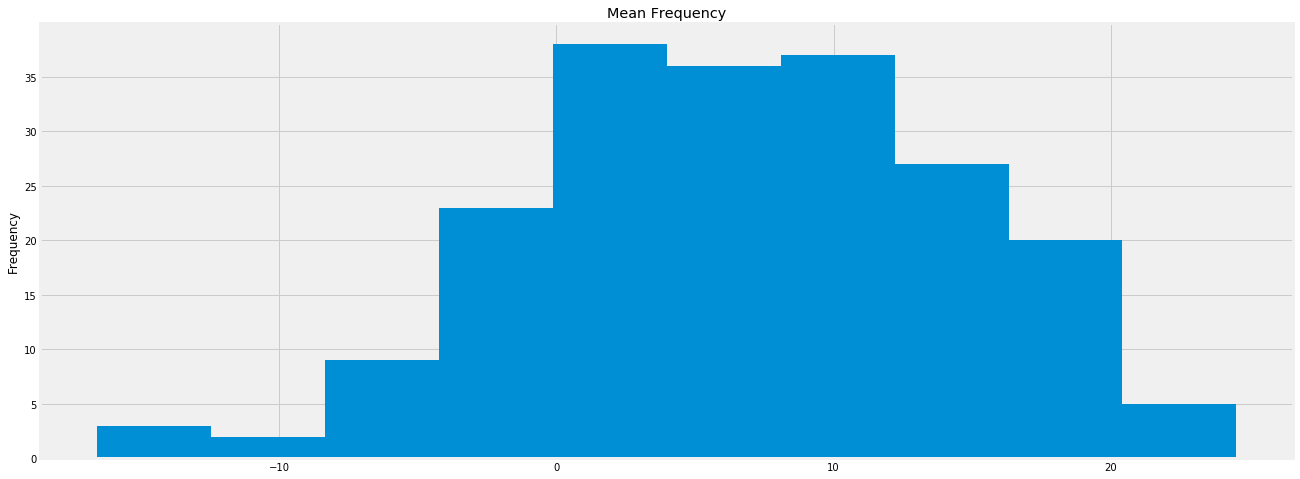

In [13]:
plt.figure(figsize=(20, 8))
train[numerical_features].mean().plot('hist');
plt.title('Mean Frequency');

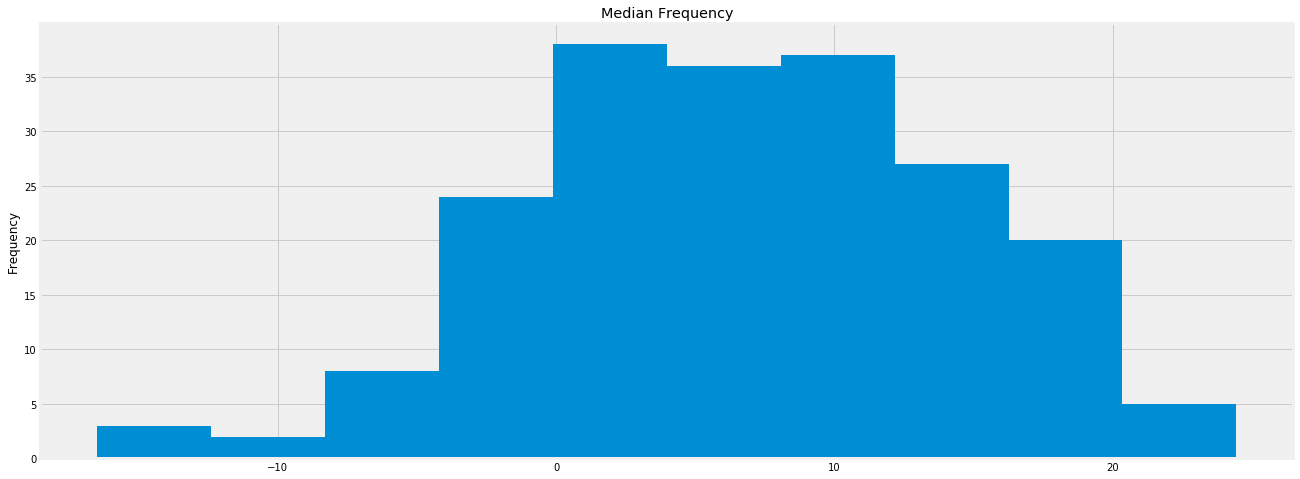

In [14]:
plt.figure(figsize=(20, 8))
train[numerical_features].median().plot('hist');
plt.title('Median Frequency');

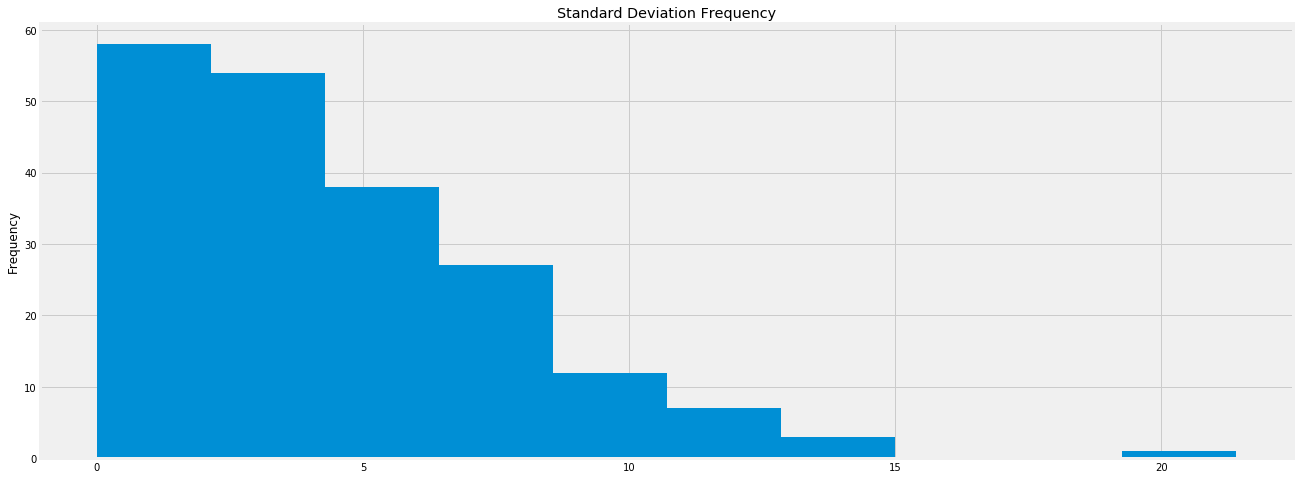

In [15]:
plt.figure(figsize=(20, 8))
train[numerical_features].std().plot('hist');
plt.title('Standard Deviation Frequency');

Most of the distributions show small std. deviations, and very few more than 20. Maybe a log transformation or a scaling technique to all features will alter the graph above to a normal one. 

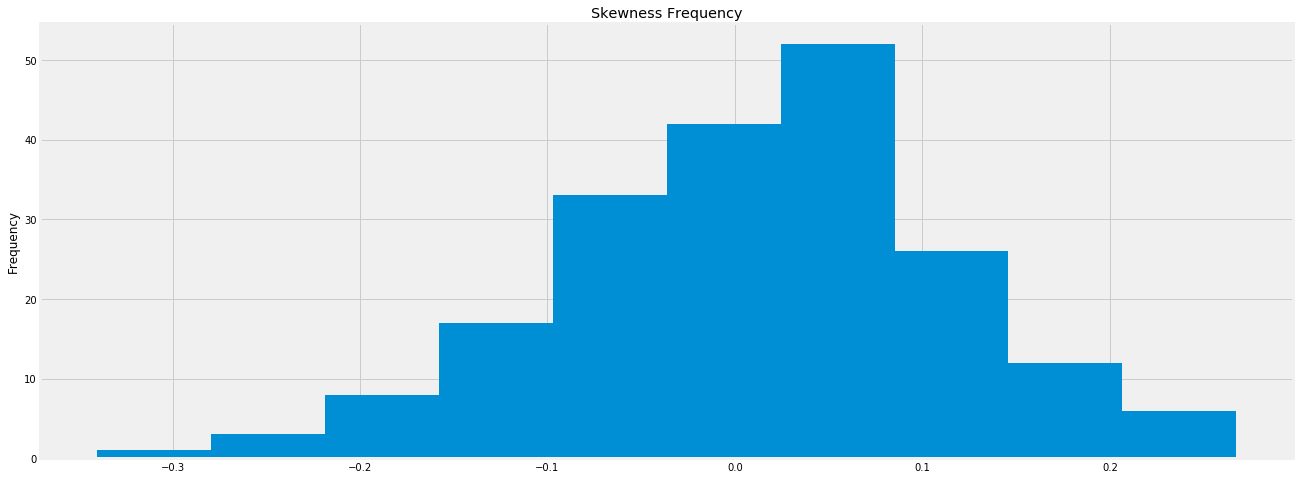

In [16]:
plt.figure(figsize=(20, 8))
train[numerical_features].skew().plot('hist');
plt.title('Skewness Frequency');

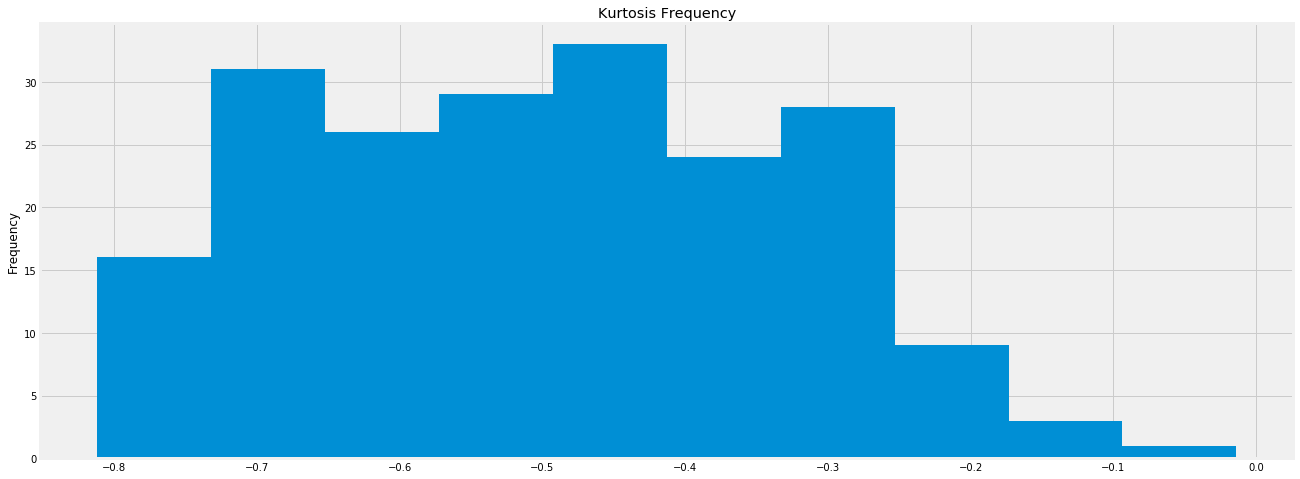

In [17]:
plt.figure(figsize=(20, 8))
train[numerical_features].kurt().plot('hist');
plt.title('Kurtosis Frequency');

Both Skewness and Kurtosis show that the features distributions are like a normal one.

#### correlations between numerical data

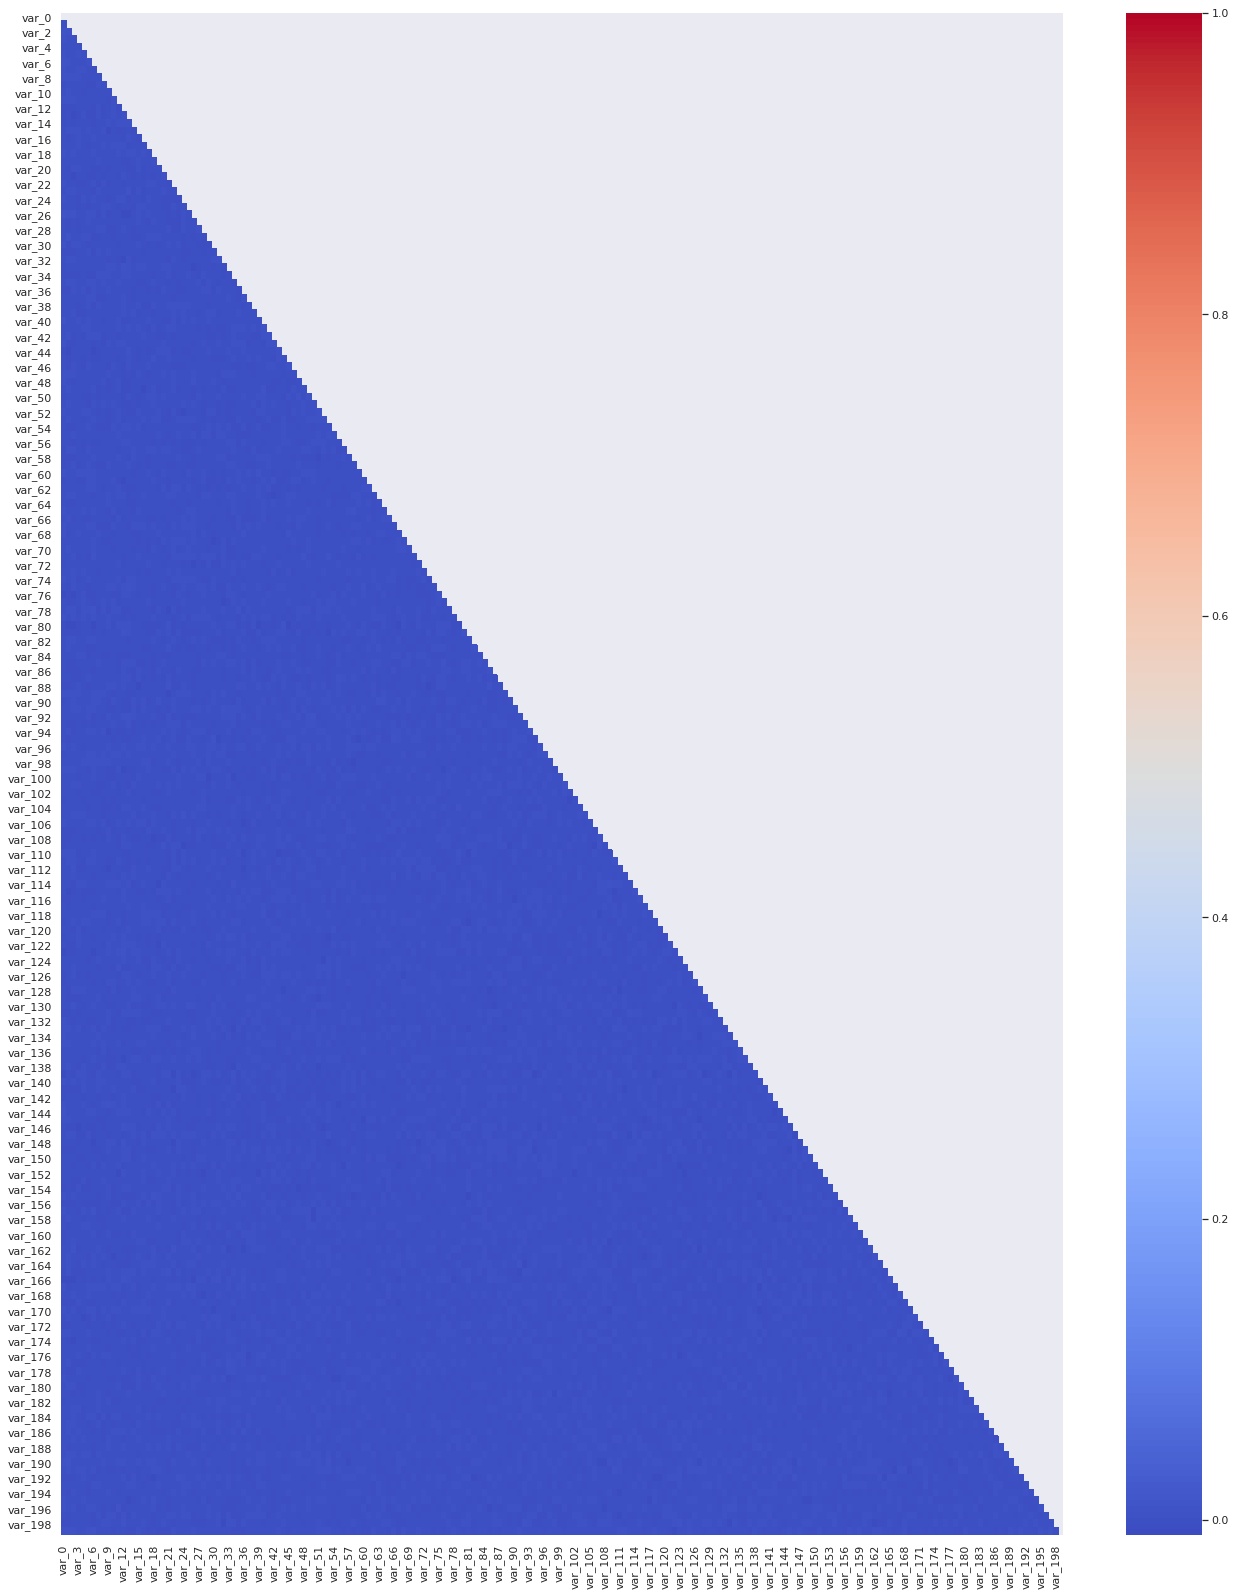

In [18]:
sns.set(rc={'figure.figsize':(20,28)})

# Compute the correlation matrix
corr = train[numerical_features].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, mask=mask, 
            #annot=True, 
            #fmt=".2f", 
            cmap='coolwarm')

the figure above shows that most of the pearson correlations between the numerical data are close to zero, in fact is between 0 and 0.2. That means that most of the numerical data are almost uncorrelated between them.

#### Most correlated features:

In [19]:
s = corr.unstack().drop_duplicates()
so = s.sort_values(kind="quicksort")
so = so.drop_duplicates()

print("Top most highly positive correlated features:")
print(so[(so<1) & (so>0.5)].sort_values(ascending=False))

print()

print("Top most highly megative correlated features:")
print(so[(so < - 0.005)])

Top most highly positive correlated features:
Series([], dtype: float64)

Top most highly megative correlated features:
var_26   var_139   -0.009844
var_53   var_148   -0.009788
var_6    var_80    -0.008958
var_1    var_80    -0.008855
var_2    var_13    -0.008795
var_81   var_155   -0.008601
var_127  var_162   -0.008555
var_54   var_179   -0.008394
var_26   var_72    -0.008062
var_34   var_133   -0.008020
var_10   var_163   -0.008002
var_2    var_80    -0.007989
var_148  var_195   -0.007932
var_34   var_138   -0.007869
var_50   var_157   -0.007859
var_67   var_169   -0.007842
var_12   var_99    -0.007828
var_91   var_165   -0.007819
var_166  var_191   -0.007798
var_139  var_170   -0.007749
         var_155   -0.007554
var_26   var_166   -0.007532
var_111  var_197   -0.007517
var_169  var_191   -0.007492
var_177  var_179   -0.007454
var_0    var_123   -0.007402
var_162  var_198   -0.007391
var_32   var_198   -0.007375
var_18   var_192   -0.007355
var_0    var_166   -0.007269
          

### EDA Summary

- We have 200 features that are mostly uncorrelated between them
- 200 numerical features that their histograms have a shape like the one of a normal distribution

## Machine Learning Modeling
<a id="ML"></a>

![](https://cmci.colorado.edu/classes/INFO-4604/fa17/wordcloud.png)
[image-source](https://cmci.colorado.edu/classes/INFO-4604/fa17/wordcloud.png)

### Feature Engineering
<a id="FE"></a>

In [20]:
train.shape, test.shape

((200000, 202), (200000, 201))

In [21]:
# special thanks to https://www.kaggle.com/gpreda/santander-eda-and-prediction
# also big help for feature engineering :https://www.kaggle.com/hjd810/keras-lgbm-aug-feature-eng-sampling-prediction
# last but not least: https://www.kaggle.com/c/santander-customer-transaction-prediction/discussion/87486#latest-506429

fs_params = dict()
fs_params["descriptives"] = True
fs_params["standardization"] = False
fs_params["percentiles"] = False
fs_params["squared"] = False
fs_params["frequency"] = True

gc.collect();
turn = 0
from sklearn.preprocessing import StandardScaler
for df in [test, train]:
    
    if turn == 0:
        print("Train set")
        turn = 1
    else:
        print("Test set")
    
    if (fs_params["descriptives"] == True):
        print('\t*descriptive statistics Feature Engineering:')
        df['sum'] = df[numerical_features].sum(axis=1)  
        df['min'] = df[numerical_features].min(axis=1)
        df['max'] = df[numerical_features].max(axis=1)
        df['mean'] = df[numerical_features].mean(axis=1)
        df['std'] = df[numerical_features].std(axis=1)
        df['skew'] = df[numerical_features].skew(axis=1)
        df['kurt'] = df[numerical_features].kurtosis(axis=1)
        df['med'] = df[numerical_features].median(axis=1)
        print('\t*descriptive statistics Feature Engineering done!')
    
    if (fs_params["standardization"] == True):
        print('\t*Standardizing the data:')
        #inf values can result from squaring
        scaler = StandardScaler()
        df[numerical_features] = scaler.fit_transform(df[numerical_features])
        print('\t*Data Standardized!')
    
    if (fs_params["percentiles"] == True):
        print('\t*percentiles Feature Engineering:')
        perc_list = [1,2,5,10,25,50,60,75,80,85,95,99]
        for i in perc_list:
            df['perc_'+str(i)] =  df[numerical_features].apply(lambda x: np.percentile(x, i), axis=1)
        print('\t*Done percentiles Feature Engineering!')
    
    if (fs_params["squared"] == True):
        print('\t*Loading Squared data:')
        for i in range(200):
            df['var_sq_'+str(i)] = np.square(df['var_'+str(i)])
        print('\t*Done squaring!')
    
    if (fs_params["frequency"] == True):
        #thanks to  https://www.kaggle.com/c/santander-customer-transaction-prediction/discussion/87486#latest-506429
        print('\t*Loading frequency:')
        for var in numerical_features:
            hist, bin_edges = np.histogram(df[var], bins=1000, density=True)
            df['hist_'+var] = [ hist[np.searchsorted(bin_edges,ele)-1] for ele in df[var]]
        print('\t*Done Loading frequency!')
    
gc.collect();

Train set
	*descriptive statistics Feature Engineering:
	*descriptive statistics Feature Engineering done!
	*Loading frequency:
	*Done Loading frequency!
Test set
	*descriptive statistics Feature Engineering:
	*descriptive statistics Feature Engineering done!
	*Loading frequency:
	*Done Loading frequency!


In [22]:
train.columns

Index(['ID_code', 'target', 'var_0', 'var_1', 'var_2', 'var_3', 'var_4',
       'var_5', 'var_6', 'var_7',
       ...
       'hist_var_190', 'hist_var_191', 'hist_var_192', 'hist_var_193',
       'hist_var_194', 'hist_var_195', 'hist_var_196', 'hist_var_197',
       'hist_var_198', 'hist_var_199'],
      dtype='object', length=410)

In [23]:
train.head(6)

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,...,hist_var_160,hist_var_161,hist_var_162,hist_var_163,hist_var_164,hist_var_165,hist_var_166,hist_var_167,hist_var_168,hist_var_169,hist_var_170,hist_var_171,hist_var_172,hist_var_173,hist_var_174,hist_var_175,hist_var_176,hist_var_177,hist_var_178,hist_var_179,hist_var_180,hist_var_181,hist_var_182,hist_var_183,hist_var_184,hist_var_185,hist_var_186,hist_var_187,hist_var_188,hist_var_189,hist_var_190,hist_var_191,hist_var_192,hist_var_193,hist_var_194,hist_var_195,hist_var_196,hist_var_197,hist_var_198,hist_var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,2.9252,3.1821,14.0137,0.5745,8.7989,14.5691,5.7487,-7.2393,4.2840,30.7133,10.5350,16.2191,2.5791,2.4716,14.3831,13.4325,-5.1488,-0.4073,4.9306,5.9965,-0.3085,12.9041,-3.8766,16.8911,11.1920,10.5785,0.6764,7.8871,...,0.032880,0.747959,0.165067,0.049858,0.012766,0.032884,0.846277,0.047689,0.036998,0.996396,0.058423,0.031191,0.042201,0.056004,0.047591,0.076647,0.036364,0.119212,0.038569,0.148793,0.051455,0.233921,0.038643,0.047697,0.016387,0.009977,0.087636,0.023745,0.068826,0.349098,0.080684,0.078833,0.202588,0.082820,0.098261,0.083911,0.052258,0.424683,0.075835,0.031327
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,8.0851,-0.4032,8.0585,14.0239,8.4135,5.4345,13.7003,13.8275,-15.5849,7.8000,28.5708,3.4287,2.7407,8.5524,3.3716,6.9779,13.8910,-11.7684,-2.5586,5.0464,0.5481,-9.2987,7.8755,1.2859,19.3710,11.3702,0.7399,2.7995,5.8434,...,0.029159,1.118507,0.180838,0.048685,0.060560,0.054468,0.791406,0.012403,0.121174,0.932796,0.044657,0.039484,0.035206,0.045308,0.025568,0.108157,0.039909,0.041868,0.037554,0.003286,0.062953,0.291844,0.011855,0.071897,0.026968,0.077992,0.117521,0.027077,0.099125,0.236021,0.056863,0.119279,0.220596,0.016797,0.101121,0.089680,0.051797,0.373357,0.101113,0.034000
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,5.9525,-0.3249,-11.2648,14.1929,7.3124,7.5244,14.6472,7.6782,-1.7395,4.7011,20.4775,17.7559,18.1377,1.2145,3.5137,5.6777,13.2177,-7.9940,-2.9029,5.8463,6.1439,-11.1025,12.4858,-2.2871,19.0422,11.0449,4.1087,4.6974,6.9346,...,0.027488,1.187127,0.231304,0.050738,0.065075,0.067796,0.842056,0.046029,0.100565,0.883330,0.030572,0.064486,0.017296,0.047712,0.041146,0.110144,0.050748,0.115377,0.031803,0.132599,0.070714,0.268452,0.016923,0.047697,0.023149,0.082488,0.068049,0.027857,0.047957,0.132050,0.083604,0.099443,0.253747,0.088641,0.079285,0.061884,0.026590,0.361767,0.110466,0.031327
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,8.2450,2.3061,2.8102,13.8463,11.9704,6.4569,14.8372,10.7430,-0.4299,15.9426,13.7257,20.3010,12.5579,6.8202,2.7229,12.1354,13.7367,0.8135,-0.9059,5.9070,2.8407,-15.2398,10.4407,-2.5731,6.1796,10.6093,-5.9158,8.1723,2.8521,...,0.032424,0.531805,0.124589,0.034461,0.033627,0.076777,0.620463,0.046990,0.049662,0.786164,0.029451,0.051861,0.041971,0.013340,0.050062,0.094531,0.013269,0.101953,0.027320,0.073223,0.061516,0.156504,0.039548,0.089433,0.017899,0.056351,0.117521,0.027360,0.090096,0.229950,0.080223,0.113869,0.190719,0.084150,0.054850,0.227609,0.046417,0.171363,0.106674,0.029546
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,7.6784,-9.4458,-12.1419,13.8481,7.8895,7.7894,15.0553,8.4871,-3.0680,6.5263,11.3152,21.4246,18.9608,10.1102,2.7142,14.2080,13.5433,3.1736,-3.3423,5.9015,7.9352,-3.1582,9.4668,-0.0083,19.3239,12.4057,0.6329,2.7922,5.8184,...,0.024375,1.591985,0.247600,0.029768,0.011832,0.062725,0.820952,0.044632,0.119436,1.012296,0.085633,0.062010,0.042893,0.061773,0.049418,0.041730,0.046291,0.108345,0.041276,0.089182,0.062809,0.258427,0.035204,0.064707,0.039139,0.063517,0.087434,0

In [24]:
test.shape

(200000, 409)

In [25]:
train.shape, test.shape

((200000, 410), (200000, 409))

In [26]:
y = train['target']
X = train.drop(['target', "ID_code"], axis=1)

In [27]:
del train

In [28]:
clf_stats_df = pd.DataFrame(columns=["clf_name", "F1-score", "auc-score"])

### Baseline Modeling
<a id="base"></a>

In [29]:
def xgboost_all_purpose(X, y, type_of_training, name, num_of_folds=3, params=None, in_folds_sampling = False, max_early_stopping = 100):
    
    from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
    from collections import Counter
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import precision_score
    from sklearn.metrics import recall_score
    from sklearn.metrics import f1_score
    from sklearn.metrics import classification_report
    from sklearn.metrics import roc_auc_score
    import scikitplot as skplt
    import time
    import random
    
    import xgboost as xgb
    
    global clf_stats_df
    
    if params is None:
        params = dict()
        params["learning_rate"] = 0.1
        params["n_estimators"] = 500
        params["max_depth"] = 2
        params["min_child_weight"] = 1
        params["gamma"] = 0
        params["subsample"] = 1
        params["colsample_bytree"] = 1
        params["colsample_bylevel"] = 1
        params["reg_alpha"] = 0
        params["reg_lambda"] = 1
        params["scale_pos_weight"] = np.round(y.value_counts()[0] / y.value_counts()[1],3)
        params["max_delta_step"] = 1
    
    print("params", params)
    print("max_early_stopping:", max_early_stopping)
    
    if type_of_training == "baseline":
        
        print("baseline")
        
        # create a 70/30 stratified split of the data 
        xtrain, xvalid, ytrain, yvalid = train_test_split(X, y, stratify = y, random_state=42, test_size=0.3)
    
        import xgboost as xgb

        start_time = time.time()
        
        predictions_probas_list = np.zeros([len(yvalid), 2])
        predictions_test = np.zeros(len(test))
        num_fold = 0
        #feature_importance_df = pd.DataFrame()
        
        folds = StratifiedKFold(n_splits=num_of_folds, shuffle=False, random_state = 42)
        
        for train_index, valid_index in folds.split(xtrain, ytrain):
            xtrain_stra, xvalid_stra = xtrain.iloc[train_index,:], xtrain.iloc[valid_index,:]
            ytrain_stra, yvalid_stra = ytrain.iloc[train_index], ytrain.iloc[valid_index]
            
            print()
            print("Stratified Fold:", num_fold)
            num_fold = num_fold + 1
            print()
            
            clf_stra_xgb = xgb.XGBClassifier(learning_rate=params["learning_rate"], 
                                    n_estimators=params["n_estimators"], 
                                    max_depth=params["max_depth"],
                                    min_child_weight=params["min_child_weight"],
                                    gamma=params["gamma"],
                                    subsample=params["subsample"],
                                    colsample_bytree=params["colsample_bytree"],
                                    colsample_bylevel=params["colsample_bylevel"],
                                    objective= 'binary:logistic',
                                    nthread=-1,
                                    scale_pos_weight=params["scale_pos_weight"],
                                    reg_alpha = params["reg_alpha"],
                                    reg_lambda = params["reg_lambda"],
                                    max_delta_step = params["max_delta_step"],
                                    seed=42)

            clf_stra_xgb.fit(xtrain_stra, ytrain_stra, eval_set=[(xtrain_stra, ytrain_stra), (xvalid_stra, yvalid_stra)], 
                        early_stopping_rounds=max_early_stopping, eval_metric='auc', verbose=100)
            
            #fold_importance_df = pd.DataFrame()
            #fold_importance_df["feature"] = pd.DataFrame.from_dict(data=clf_stra_xgb.get_fscore(), orient="index", columns=["FScore"])["FScore"].index
            #fold_importance_df["fscore"] = pd.DataFrame.from_dict(data=clf_stra_xgb.get_fscore(), orient="index", columns=["FScore"])["FScore"].values
            #fold_importance_df["fold"] = n_fold + 1
            #feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

            predictions = clf_stra_xgb.predict(xvalid)
            predictions_probas = clf_stra_xgb.predict_proba(xvalid)
            predictions_probas_list += predictions_probas/num_of_folds
            
            predictions_test += clf_stra_xgb.predict_proba(test.drop("ID_code", axis="columns")[xtrain.columns])[:,1]/num_of_folds
            
        
        predictions = np.argmax(predictions_probas, axis=1)

        print()
        print(classification_report(yvalid, predictions))

        print()
        print("CV f1_score", f1_score(yvalid, predictions, average = "macro"))
        
        print()
        print("CV roc_auc_score", roc_auc_score(yvalid, predictions_probas_list[:,1], average = "macro"))
        
        print()
        print("elapsed time in seconds: ", time.time() - start_time)
        
        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_confusion_matrix(yvalid, predictions, normalize=True)
        
        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_roc(yvalid, predictions_probas)
        
        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_ks_statistic(yvalid, predictions_probas)
        
        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_precision_recall(yvalid, predictions_probas)
        
        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_cumulative_gain(yvalid, predictions_probas)

        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_lift_curve(yvalid, predictions_probas)
        
        sns.set(rc={'figure.figsize':(12, 38)})
        xgb.plot_importance(clf_stra_xgb, title='Feature importance', xlabel='F score', ylabel='Features')

        clf_stats_df = clf_stats_df.append({"clf_name": name,
                             "F1-score":f1_score(yvalid, predictions, average = "macro"),
                             "auc-score": roc_auc_score(yvalid, predictions_probas[:,1], average = "macro")}, ignore_index=True)
        
        print()
        gc.collect();
        return clf_stra_xgb, predictions_test

    
    elif type_of_training == "oversampling":
        
        print("oversampling")
        #### resampling techniques:
        from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler

        # create a 70/30 split of the data 
        xtrain, xvalid, ytrain, yvalid = train_test_split(X, y, stratify = y, random_state=42, test_size=0.3)

        # RandomOverSampler
        ros = RandomOverSampler(random_state=42)
        X_resampled, y_resampled = ros.fit_resample(xtrain, ytrain)
        
        from collections import Counter
        print(sorted(Counter(y_resampled).items()))
        
        xtrain=pd.DataFrame(X_resampled, columns = X.columns)
        ytrain = y_resampled
        del X_resampled
        del y_resampled
        
        predictions_probas_list = np.zeros([len(yvalid), 2])
        predictions_test = np.zeros(len(test))
        num_fold = 0        

        start_time = time.time()
        
        folds = KFold(n_splits=num_of_folds, shuffle=False, random_state = 42)
        
        for train_index, valid_index in folds.split(xtrain, ytrain):
            xtrain_stra, xvalid_stra = xtrain.iloc[train_index,:], xtrain.iloc[valid_index,:]
            ytrain_stra, yvalid_stra = ytrain[train_index], ytrain[valid_index]
            
            print()
            print("Fold:", num_fold)
            num_fold = num_fold + 1
            print()

            clf_ros_xgb = xgb.XGBClassifier(learning_rate=params["learning_rate"], 
                                        n_estimators=params["n_estimators"], 
                                        max_depth=params["max_depth"],
                                        min_child_weight=params["min_child_weight"],
                                        gamma=params["gamma"],
                                        subsample=params["subsample"],
                                        colsample_bytree=params["colsample_bytree"],
                                        colsample_bylevel=params["colsample_bylevel"],
                                        objective= 'binary:logistic',
                                        nthread=-1,
                                        scale_pos_weight=params["scale_pos_weight"],
                                        reg_alpha = params["reg_alpha"],
                                        reg_lambda = params["reg_lambda"],
                                        max_delta_step = params["max_delta_step"],
                                        seed=42)

            clf_ros_xgb.fit(xtrain_stra, ytrain_stra, eval_set=[(xtrain_stra, ytrain_stra), (xvalid_stra, yvalid_stra)], 
                    early_stopping_rounds=max_early_stopping, eval_metric='auc', verbose=100)

            predictions = clf_ros_xgb.predict(xvalid)
            predictions_probas = clf_ros_xgb.predict_proba(xvalid)
            predictions_probas_list += predictions_probas/num_of_folds  
            
            predictions_test += clf_ros_xgb.predict_proba(test.drop("ID_code", axis="columns")[xtrain.columns])[:,1]/num_of_folds
            
        predictions = np.argmax(predictions_probas, axis=1)
            
        print()
        print(classification_report(yvalid, predictions))

        print()
        print("f1_score", f1_score(yvalid, predictions, average = "macro"))
        
        print()
        print("roc_auc_score", roc_auc_score(yvalid, predictions_probas[:,1], average = "macro"))

        print()
        print("elapsed time in seconds: ", time.time() - start_time)
        
        sns.set(rc={'figure.figsize':(8, 8)})
        skplt.metrics.plot_confusion_matrix(yvalid, predictions, normalize=True)
        
        skplt.metrics.plot_roc(yvalid, predictions_probas)
        
        skplt.metrics.plot_precision_recall(yvalid, predictions_probas)
        
        sns.set(rc={'figure.figsize':(12, 38)})
        xgb.plot_importance(clf_ros_xgb, title='Feature importance', xlabel='F score', ylabel='Features')
        
        clf_stats_df = clf_stats_df.append({"clf_name": name,
                             "F1-score":f1_score(yvalid, predictions, average = "macro"),
                             "auc-score": roc_auc_score(yvalid, predictions_probas[:,1], average = "macro")}, ignore_index=True)

        print()
        gc.collect();
        return clf_ros_xgb, predictions_test
    
    # still needs some work to work
    elif type_of_training == "smote":
        print("smote")
        #### resampling techniques, I will use Synthetic minority:
        from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler

        # create a 70/30 split of the data 
        xtrain, xvalid, ytrain, yvalid = train_test_split(X, y, stratify = y, random_state=42, test_size=0.3)

        # SMOTE
        smote = SMOTE(random_state=42)
        X_resampled, y_resampled = smote.fit_resample(xtrain, ytrain)
        
        from collections import Counter
        print(sorted(Counter(y_resampled).items()))
        
        xtrain=pd.DataFrame(X_resampled, columns = X.columns)
        ytrain = y_resampled

        start_time = time.time()

        clf_smote_xgb = xgb.XGBClassifier(learning_rate=params["learning_rate"], 
                                    n_estimators=params["n_estimators"], 
                                    max_depth=params["max_depth"],
                                    min_child_weight=params["min_child_weight"],
                                    gamma=params["gamma"],
                                    subsample=params["subsample"],
                                    colsample_bytree=params["colsample_bytree"],
                                    objective= 'binary:logistic',
                                    nthread=-1,
                                    scale_pos_weight=params["scale_pos_weight"],
                                    reg_alpha = params["reg_alpha"],
                                    reg_lambda = params["reg_lambda"],
                                    max_delta_step = params["max_delta_step"],
                                    seed=42)

        clf_smote_xgb.fit(xtrain, ytrain, eval_set=[(xtrain, ytrain), (xvalid, yvalid)], 
                    early_stopping_rounds=max_early_stopping, eval_metric='auc', verbose=100)

        predictions = clf_smote_xgb.predict(xvalid)
        predictions_probas = clf_smote_xgb.predict_proba(xvalid)

        print()
        print(classification_report(yvalid, predictions))

        print()
        print("f1_score", f1_score(yvalid, predictions, average = "macro"))
        
        print()
        print("roc_auc_score", roc_auc_score(yvalid, predictions_probas[:,1], average = "macro"))

        print()
        print("elapsed time in seconds: ", time.time() - start_time)
        
        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_confusion_matrix(yvalid, predictions, normalize=True)
        
        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_roc(yvalid, predictions_probas)
        
        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_ks_statistic(yvalid, predictions_probas)
        
        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_precision_recall(yvalid, predictions_probas)
        
        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_cumulative_gain(yvalid, predictions_probas)

        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_lift_curve(yvalid, predictions_probas)
        
        sns.set(rc={'figure.figsize':(12, 38)})
        xgb.plot_importance(clf_smote_xgb, title='Feature importance', xlabel='F score', ylabel='Features')
        
        clf_stats_df = clf_stats_df.append({"clf_name": name,
                             "F1-score":f1_score(yvalid, predictions, average = "macro"),
                             "auc-score": roc_auc_score(yvalid, predictions_probas[:,1], average = "macro")}, ignore_index=True)

        print()
        gc.collect();
        return clf_smote_xgb
    
    # still needs some work to work
    elif type_of_training == "undersampling":
        print("undersampling")
        #### resampling techniques:
        from imblearn.under_sampling import RandomUnderSampler

        # create a 70/30 split of the data 
        xtrain, xvalid, ytrain, yvalid = train_test_split(X, y, random_state=42, test_size=0.3)

        # RandomUnderSampler
        rus = RandomUnderSampler(random_state=42)
        X_resampled, y_resampled = rus.fit_resample(xtrain, ytrain)
        
        print(sorted(Counter(y_resampled).items()))
        
        xtrain=pd.DataFrame(X_resampled, columns = X.columns)
        ytrain = y_resampled

        start_time = time.time()

        clf_rus_xgb = xgb.XGBClassifier(learning_rate=params["learning_rate"], 
                                    n_estimators=params["n_estimators"], 
                                    max_depth=params["max_depth"],
                                    min_child_weight=params["min_child_weight"],
                                    gamma=params["gamma"],
                                    subsample=params["subsample"],
                                    colsample_bytree=params["colsample_bytree"],
                                    objective= 'binary:logistic',
                                    nthread=-1,
                                    scale_pos_weight=params["scale_pos_weight"],
                                    reg_alpha = params["reg_alpha"],
                                    reg_lambda = params["reg_lambda"],
                                    max_delta_step = params["max_delta_step"],
                                    seed=42)

        clf_rus_xgb.fit(xtrain, ytrain, eval_set=[(xtrain, ytrain), (xvalid, yvalid)], 
                    early_stopping_rounds=max_early_stopping, eval_metric='auc', verbose=100)

        predictions = clf_rus_xgb.predict(xvalid)
        predictions_probas = clf_rus_xgb.predict_proba(xvalid)
        
        
        print()
        print(classification_report(yvalid, predictions))

        print()
        print("f1_score", f1_score(yvalid, predictions, average = "macro"))
        
        print()
        print("roc_auc_score", roc_auc_score(yvalid, predictions_probas[:,1], average = "macro"))

        print()
        print("elapsed time in seconds: ", time.time() - start_time)
        
        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_confusion_matrix(yvalid, predictions, normalize=True)
        
        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_roc(yvalid, predictions_probas)
        
        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_ks_statistic(yvalid, predictions_probas)
        
        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_precision_recall(yvalid, predictions_probas)
        
        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_cumulative_gain(yvalid, predictions_probas)

        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_lift_curve(yvalid, predictions_probas)
        
        sns.set(rc={'figure.figsize':(12, 38)})
        xgb.plot_importance(clf_rus_xgb, title='Feature importance', xlabel='F score', ylabel='Features')
        
        clf_stats_df = clf_stats_df.append({"clf_name": name,
                             "F1-score":f1_score(yvalid, predictions, average = "macro"),
                             "auc-score": roc_auc_score(yvalid, predictions_probas[:,1], average = "macro")}, ignore_index=True)

        print()
        gc.collect();
        #return clf_rus_xgb, predictions, predictions_probas
        return clf_rus_xgb
    
    elif type_of_training == "augmentation":
        
        print("augmentation_by_fraction")
        
        # create a 70/30 split of the data 
        xtrain, xvalid, ytrain, yvalid = train_test_split(X, y, stratify=y, random_state=42, test_size=0.3)
        
        print("ytrain target values count before augmentation:\n", sorted(Counter(ytrain).items()))
        
        #thanks to https://www.kaggle.com/jiweiliu/lgb-2-leaves-augment
        def augment(x,y,t=2):
            xs,xn = [],[]
            for i in range(t):
                mask = y>0
                x1 = x[mask].copy()
                ids = np.arange(x1.shape[0])
                for c in range(x1.shape[1]):
                    np.random.shuffle(ids)
                    x1[:,c] = x1[ids][:,c]
                xs.append(x1)

            for i in range(t//2):
                mask = y==0
                x1 = x[mask].copy()
                ids = np.arange(x1.shape[0])
                for c in range(x1.shape[1]):
                    np.random.shuffle(ids)
                    x1[:,c] = x1[ids][:,c]
                xn.append(x1)

            xs = np.vstack(xs)
            xn = np.vstack(xn)
            ys = np.ones(xs.shape[0])
            yn = np.zeros(xn.shape[0])
            x = np.vstack([x,xs,xn])
            y = np.concatenate([y,ys,yn])
            return x,y
        
        start_time = time.time()
        
        predictions_probas_list = np.zeros([len(yvalid), 2])
        predictions_test = np.zeros(len(test))
        num_fold = 0
        #feature_importance_df = pd.DataFrame()
        
        folds = StratifiedKFold(n_splits=num_of_folds, shuffle=False, random_state = 42)
        
        for train_index, valid_index in folds.split(xtrain, ytrain):
            xtrain_stra, xvalid_stra = xtrain.iloc[train_index,:], xtrain.iloc[valid_index,:]
            ytrain_stra, yvalid_stra = ytrain[train_index], ytrain[valid_index]
            
            print()
            print("Stratified Fold:", num_fold)
            num_fold = num_fold + 1
            print()
            
            X_t, ytrain_stra = augment(xtrain_stra.values, ytrain_stra.values)
            print('\tAugmentation Succeeded..')
            xtrain_stra = pd.DataFrame(X_t, columns=X.columns)
            del X_t

            clf_aug_xgb = xgb.XGBClassifier(learning_rate=params["learning_rate"], 
                                        n_estimators=params["n_estimators"], 
                                        max_depth=params["max_depth"],
                                        min_child_weight=params["min_child_weight"],
                                        gamma=params["gamma"],
                                        subsample=params["subsample"],
                                        colsample_bytree=params["colsample_bytree"],
                                        colsample_bylevel=params["colsample_bylevel"],
                                        objective= 'binary:logistic',
                                        nthread=-1,
                                        scale_pos_weight=params["scale_pos_weight"],
                                        reg_alpha = params["reg_alpha"],
                                        reg_lambda = params["reg_lambda"],
                                        max_delta_step = params["max_delta_step"],
                                        seed=42)

            clf_aug_xgb.fit(xtrain_stra, ytrain_stra, eval_set=[(xtrain_stra, ytrain_stra), (xvalid_stra, yvalid_stra)], 
                    early_stopping_rounds=max_early_stopping, eval_metric='auc', verbose=100)
            
            #fold_importance_df = pd.DataFrame()
            #fold_importance_df["feature"] = pd.DataFrame.from_dict(data=clf_aug_xgb.get_fscore(), orient="index", columns=["FScore"])["FScore"].index
            #fold_importance_df["fscore"] = pd.DataFrame.from_dict(data=clf_aug_xgb.get_fscore(), orient="index", columns=["FScore"])["FScore"].values
            #fold_importance_df["fold"] = n_fold + 1
            #feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

            predictions = clf_aug_xgb.predict(xvalid)
            predictions_probas = clf_aug_xgb.predict_proba(xvalid)
            predictions_probas_list += predictions_probas/num_of_folds  
            
            predictions_test += clf_aug_xgb.predict_proba(test.drop("ID_code", axis="columns")[xtrain.columns])[:,1]/num_of_folds
            
        
        predictions = np.argmax(predictions_probas, axis=1)

        print()
        print(classification_report(yvalid, predictions))

        print()
        print("CV f1_score", f1_score(yvalid, predictions, average = "macro"))
        
        print()
        print("CV roc_auc_score", roc_auc_score(yvalid, predictions_probas[:,1], average = "macro"))

        print()
        print("elapsed time in seconds: ", time.time() - start_time)
        
        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_confusion_matrix(yvalid, predictions, normalize=True)
        
        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_roc(yvalid, predictions_probas)
        
        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_ks_statistic(yvalid, predictions_probas)
        
        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_precision_recall(yvalid, predictions_probas)
        
        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_cumulative_gain(yvalid, predictions_probas)

        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_lift_curve(yvalid, predictions_probas)
        
        sns.set(rc={'figure.figsize':(12, 38)})
        xgb.plot_importance(clf_aug_xgb, title='Feature importance', xlabel='F score', ylabel='Features')
        
        clf_stats_df = clf_stats_df.append({"clf_name": name,
                             "F1-score":f1_score(yvalid, predictions, average = "macro"),
                             "auc-score": roc_auc_score(yvalid, predictions_probas[:,1], average = "macro")}, ignore_index=True)

        print()
        gc.collect();
        #return clf_rus_xgb, predictions, predictions_probas
        return clf_aug_xgb, predictions_test
    
    
    elif type_of_training == "augmentation_by_fraction":
        
        # the main idea here is to reducing the imbalance ratio from 9:1 to 3:1 without using a manual function for resampling as the previous elif statement
        print("augmentation_by_fraction")
        
        # create a 70/30 split of the data 
        xtrain, xvalid, ytrain, yvalid = train_test_split(X, y, stratify=y, random_state=42, test_size=0.3)

        print("ytrain target values count before augmentation:\n", sorted(Counter(ytrain).items()))

        
        def augment_by_frac(xtrain, ytrain):
            
            from collections import Counter
            # Augmenting both minority and majority classes via RandomOverSampler by 3 times

            X_y = pd.DataFrame(xtrain, columns=xtrain.columns)
            X_y["target"] = ytrain
            X_y = X_y.sample(frac=3, replace=True)
            X_y.target.value_counts()
            ytrain = X_y['target']
            print("ytrain target values count after oversampling:\n",sorted(Counter(ytrain).items()))
            xtrain = X_y.drop(['target'], axis=1)
            del X_y

            from imblearn.under_sampling import RandomUnderSampler

            # reducing the majority class almost back to its original form
            rus = RandomUnderSampler(sampling_strategy=0.33, random_state=42)
            X_resampled, y_resampled = rus.fit_resample(xtrain, ytrain)

            print("ytrain target values count after Augmentation:\n",sorted(Counter(y_resampled).items()))

            xtrain=pd.DataFrame(X_resampled, columns = xtrain.columns)
            ytrain = y_resampled

            del X_resampled
            del y_resampled

            return xtrain, ytrain
        
        
        if in_folds_sampling == False:
            print("augmentation before stratification")
            xtrain, ytrain = augment_by_frac(xtrain, ytrain)

        start_time = time.time()
        
        predictions_probas_list = np.zeros([len(yvalid), 2])
        predictions_test = np.zeros(len(test))
        num_fold = 0
        #feature_importance_df = pd.DataFrame()
        
        folds = StratifiedKFold(n_splits=num_of_folds, shuffle=False, random_state = 42)
        
        for train_index, valid_index in folds.split(xtrain, ytrain):
            xtrain_stra, xvalid_stra = xtrain.iloc[train_index,:], xtrain.iloc[valid_index,:]
            ytrain_stra, yvalid_stra = ytrain[train_index], ytrain[valid_index]
                        
            print()
            print("Stratified Fold:", num_fold)
            num_fold = num_fold + 1
            print()
            
            #if in_folds_sampling is True:
            #    print("augmentation during stratification")
            #    xtrain_stra, ytrain_stra = augment_by_frac(xtrain_stra, ytrain_stra)

            clf_aug_xgb = xgb.XGBClassifier(learning_rate=params["learning_rate"], 
                                        n_estimators=params["n_estimators"], 
                                        max_depth=params["max_depth"],
                                        min_child_weight=params["min_child_weight"],
                                        gamma=params["gamma"],
                                        subsample=params["subsample"],
                                        colsample_bytree=params["colsample_bytree"],
                                        colsample_bylevel=params["colsample_bylevel"],
                                        objective= 'binary:logistic',
                                        nthread=-1,
                                        scale_pos_weight=params["scale_pos_weight"],
                                        reg_alpha = params["reg_alpha"],
                                        reg_lambda = params["reg_lambda"],
                                        max_delta_step = params["max_delta_step"],
                                        seed=42)

            clf_aug_xgb.fit(xtrain_stra, ytrain_stra, eval_set=[(xtrain_stra, ytrain_stra), (xvalid_stra, yvalid_stra)], 
                    early_stopping_rounds=max_early_stopping, eval_metric='auc', verbose=100)
            
            #fold_importance_df = pd.DataFrame()
            #fold_importance_df["feature"] = pd.DataFrame.from_dict(data=clf_aug_xgb.get_fscore(), orient="index", columns=["FScore"])["FScore"].index
            #fold_importance_df["fscore"] = pd.DataFrame.from_dict(data=clf_aug_xgb.get_fscore(), orient="index", columns=["FScore"])["FScore"].values
            #fold_importance_df["fold"] = n_fold + 1
            #feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

            predictions = clf_aug_xgb.predict(xvalid)
            predictions_probas = clf_aug_xgb.predict_proba(xvalid)
            predictions_probas_list += predictions_probas/num_of_folds  
            
            predictions_test += clf_aug_xgb.predict_proba(test.drop("ID_code", axis="columns")[xtrain.columns])[:,1]/num_of_folds
            
        
        predictions = np.argmax(predictions_probas, axis=1)

        print()
        print(classification_report(yvalid, predictions))

        print()
        print("CV f1_score", f1_score(yvalid, predictions, average = "macro"))
        
        print()
        print("CV roc_auc_score", roc_auc_score(yvalid, predictions_probas[:,1], average = "macro"))

        print()
        print("elapsed time in seconds: ", time.time() - start_time)
        
        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_confusion_matrix(yvalid, predictions, normalize=True)
        
        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_roc(yvalid, predictions_probas)
        
        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_ks_statistic(yvalid, predictions_probas)
        
        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_precision_recall(yvalid, predictions_probas)
        
        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_cumulative_gain(yvalid, predictions_probas)

        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_lift_curve(yvalid, predictions_probas)
        
        sns.set(rc={'figure.figsize':(12, 38)})
        xgb.plot_importance(clf_aug_xgb, title='Feature importance', xlabel='F score', ylabel='Features')
        
        clf_stats_df = clf_stats_df.append({"clf_name": name,
                             "F1-score":f1_score(yvalid, predictions, average = "macro"),
                             "auc-score": roc_auc_score(yvalid, predictions_probas[:,1], average = "macro")}, ignore_index=True)

        print()
        gc.collect();
        #return clf_rus_xgb, predictions, predictions_probas
        return clf_aug_xgb, predictions_test
    
    else:
        print("Please specify for the argument 'type_of_training'one of the following parameters: (baseline, oversampling, smote, undersampling, augmentation_by_fraction)")

params {'learning_rate': 0.1, 'n_estimators': 500, 'max_depth': 2, 'min_child_weight': 1, 'gamma': 0, 'subsample': 1, 'colsample_bytree': 1, 'colsample_bylevel': 1, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 8.951, 'max_delta_step': 1}
max_early_stopping: 100
augmentation_by_fraction
ytrain target values count before augmentation:
 [(0, 125931), (1, 14069)]
augmentation before stratification
ytrain target values count after oversampling:
 [(0, 377451), (1, 42549)]


Using TensorFlow backend.


ytrain target values count after Augmentation:
 [(0, 128936), (1, 42549)]

Stratified Fold: 0

[0]	validation_0-auc:0.575953	validation_1-auc:0.578696
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.834194	validation_1-auc:0.823523
[200]	validation_0-auc:0.874863	validation_1-auc:0.861396
[300]	validation_0-auc:0.894339	validation_1-auc:0.87931
[400]	validation_0-auc:0.90747	validation_1-auc:0.891582
[499]	validation_0-auc:0.916335	validation_1-auc:0.89949

Stratified Fold: 1

[0]	validation_0-auc:0.58579	validation_1-auc:0.580958
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.835405	validation_1-auc:0.822302
[200]	validation_0-auc:0.876619	validation_1-auc:0.860056
[300]	validation_0-auc:0.896441	validation_1-auc:0.878

/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


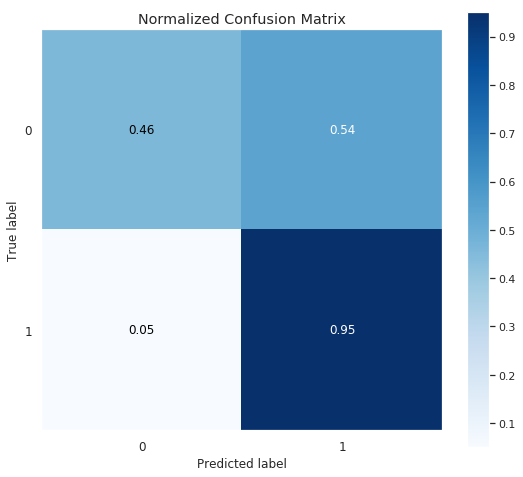

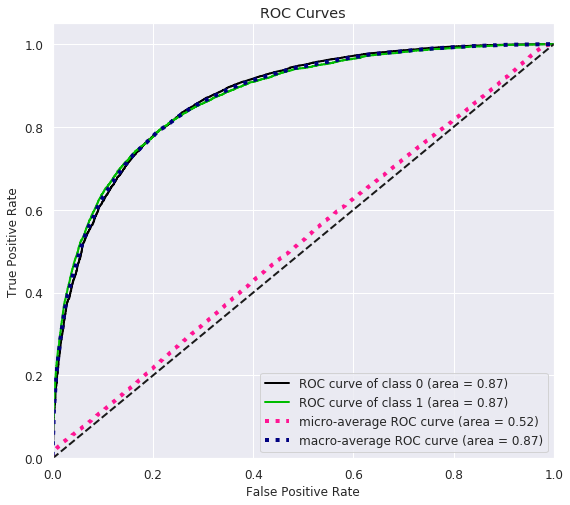

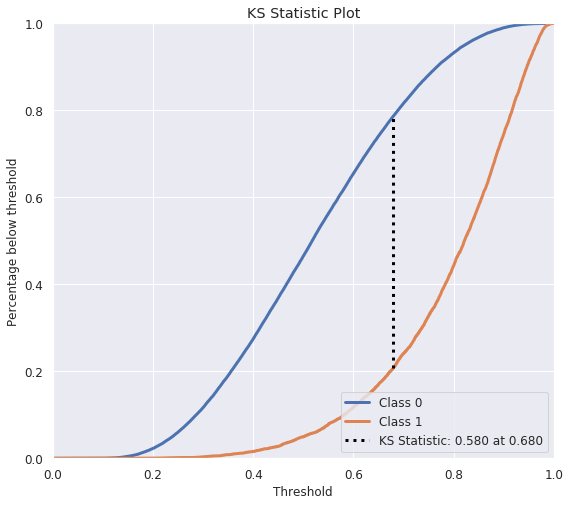

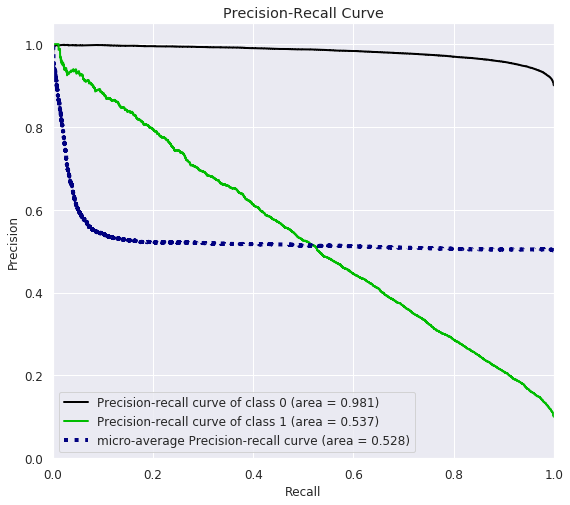

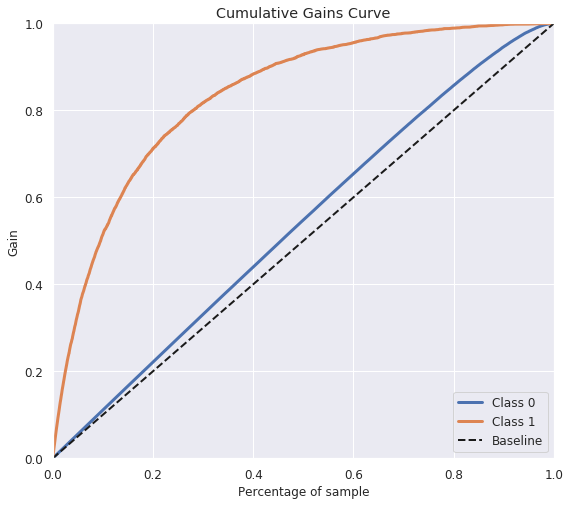

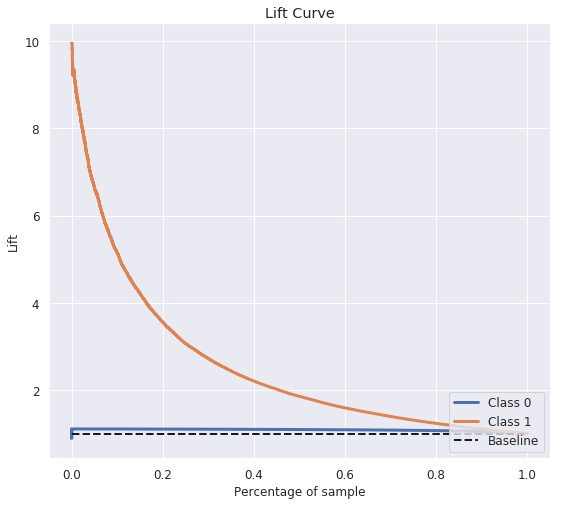

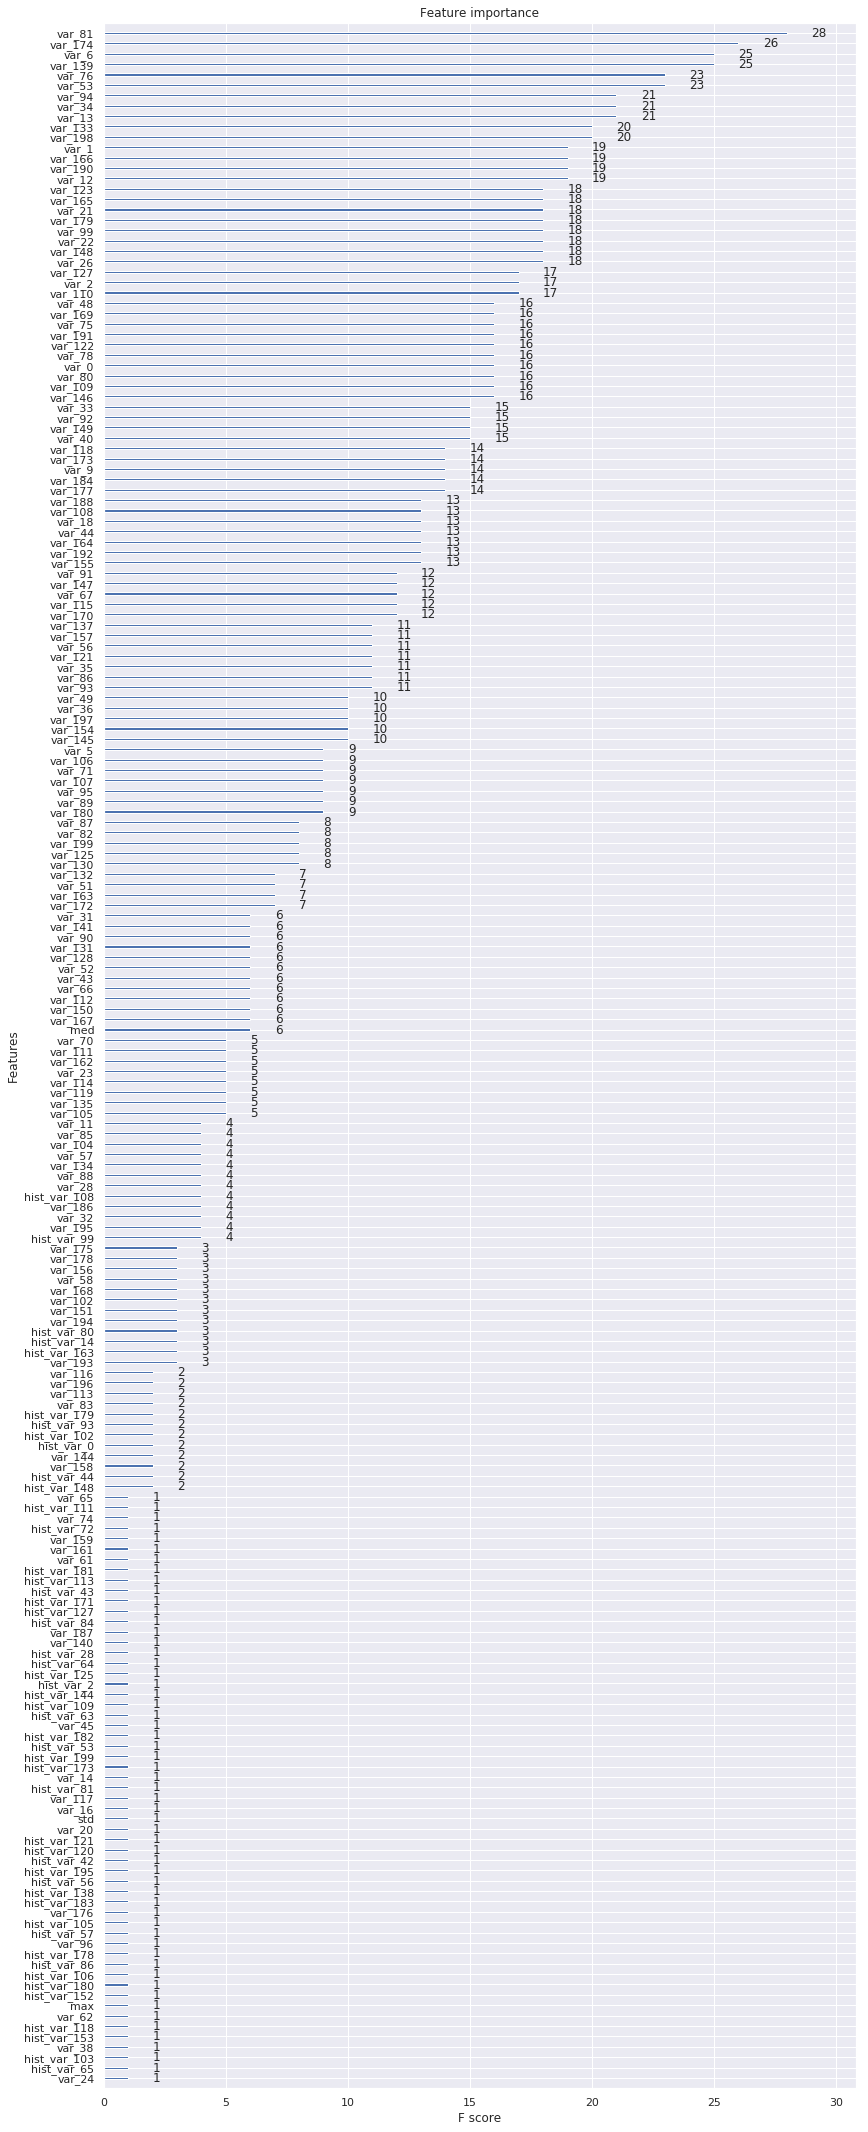

In [30]:
untuned_model_flag = True
type_of_training = "augmentation_by_fraction"

if untuned_model_flag == True:
    
    num_of_folds = 2 ### must be more than 2
    in_folds_sampling = False

    clf_xgb, predictions_test_xgb = xgboost_all_purpose(X,y, num_of_folds = num_of_folds, 
                                                        type_of_training =type_of_training, 
                                                        in_folds_sampling = in_folds_sampling, 
                                                        max_early_stopping = 100, 
                                                        name="clf_xgb")
    
    del clf_xgb

#### Test set predictions probabilities histogram

In [ ]:
if untuned_model_flag == True:
    sns.set(rc={'figure.figsize':(8,8)})
    plt.hist(predictions_test_xgb)

### Feature Selection - Permutation Importance
<a id="FS"></a>

In [31]:
gc.collect()
feature_selection_flag = True

if feature_selection_flag == True:
    from sklearn.model_selection import train_test_split
    from sklearn.ensemble import RandomForestClassifier

    gc.collect();
    xtrain, xvalid, ytrain, yvalid = train_test_split(X, y, stratify = y, test_size=0.3, random_state=42)


    rfc_model = RandomForestClassifier(random_state=42, class_weight={0: 1, 1: np.round(y.value_counts()[0] / y.value_counts()[1],3)}).fit(xtrain, ytrain)

    import eli5
    from eli5.sklearn import PermutationImportance

    perm = PermutationImportance(rfc_model, random_state=42).fit(xvalid, yvalid)

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [32]:
if feature_selection_flag == True:
    eli5.show_weights(perm, feature_names = xvalid.columns.tolist(), top=100)

#### Select top 100 features after permutation importance:

In [35]:
if feature_selection_flag == True:
    from sklearn.feature_selection import SelectFromModel

    max_selected_features = 300
    sel = SelectFromModel(perm, max_features = max_selected_features, prefit=True)

    feature_idx = sel.get_support()
    selected_feature_names = X.columns[feature_idx]

    
    X_fs = X[selected_feature_names]
    print(X_fs.shape)

    del xtrain
    del xvalid
    del ytrain
    del yvalid
    del rfc_model
    del eli5
    del perm
    del max_selected_features
    del sel
    del feature_idx
    del selected_feature_names

(200000, 233)


### XGBoost Training after Feature Selection

params {'learning_rate': 0.1, 'n_estimators': 500, 'max_depth': 2, 'min_child_weight': 1, 'gamma': 0, 'subsample': 1, 'colsample_bytree': 1, 'colsample_bylevel': 1, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 8.951, 'max_delta_step': 1}
max_early_stopping: 100
augmentation_by_fraction
ytrain target values count before augmentation:
 [(0, 125931), (1, 14069)]
augmentation before stratification
ytrain target values count after oversampling:
 [(0, 377728), (1, 42272)]
ytrain target values count after Augmentation:
 [(0, 128096), (1, 42272)]

Stratified Fold: 0

[0]	validation_0-auc:0.575265	validation_1-auc:0.56948
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.77995	validation_1-auc:0.765433
[200]	validation_0-auc:0.818285	validation_1-auc:0.799573
[300]	validation_0-auc:0.839838	validation_1-auc:0.81849
[400]	validation_0-auc:0.85197	validation

/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


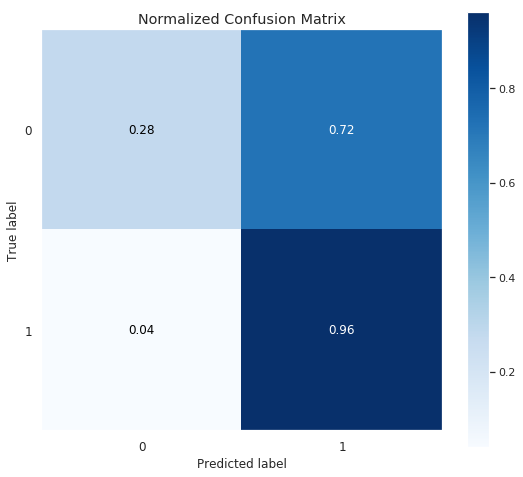

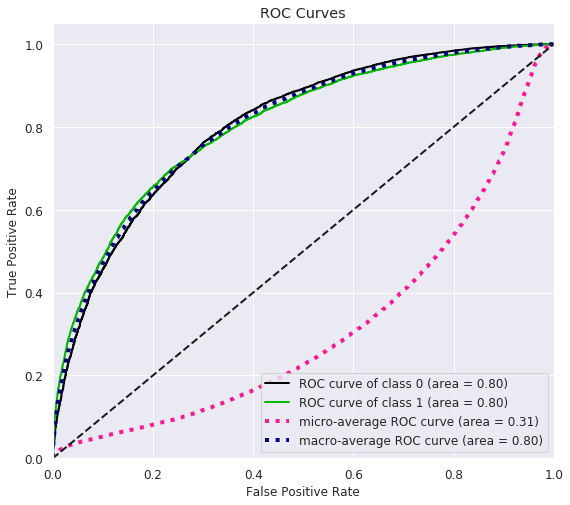

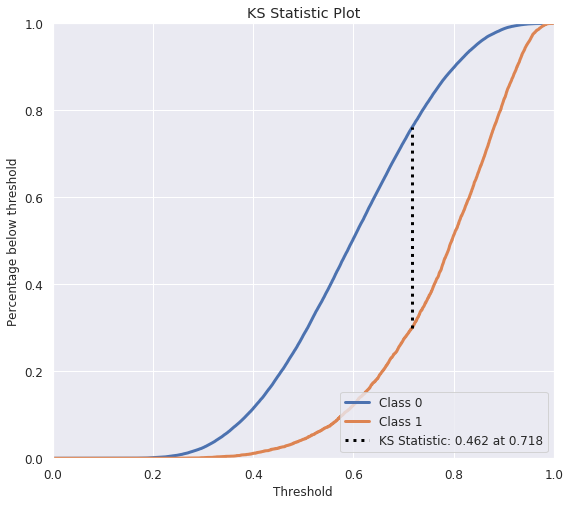

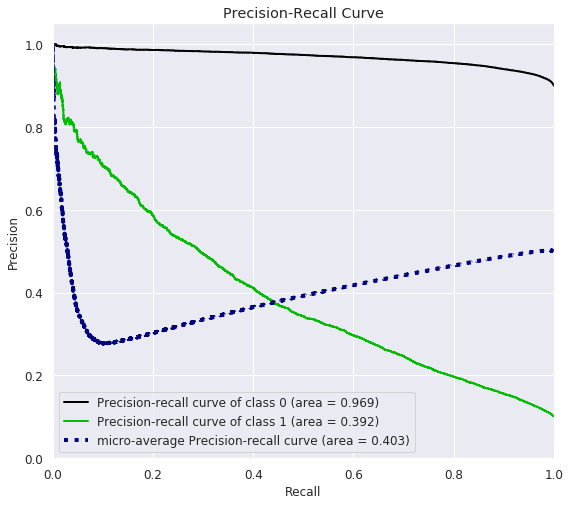

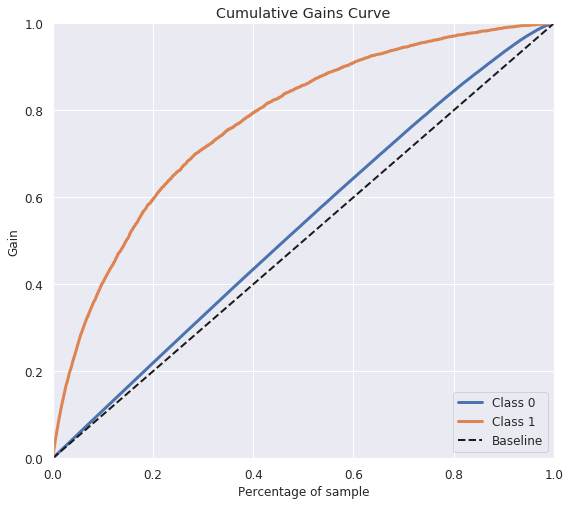

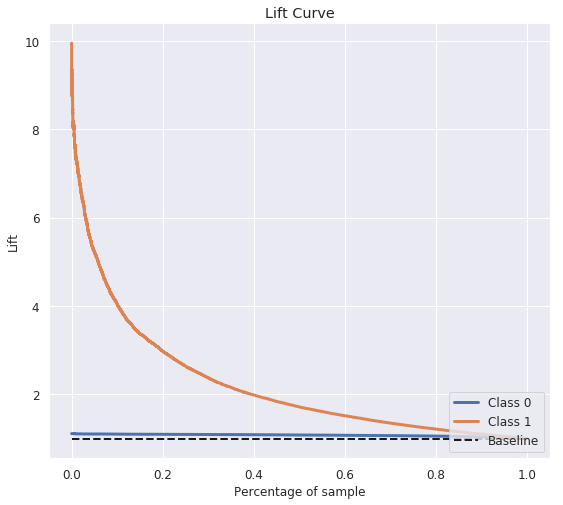

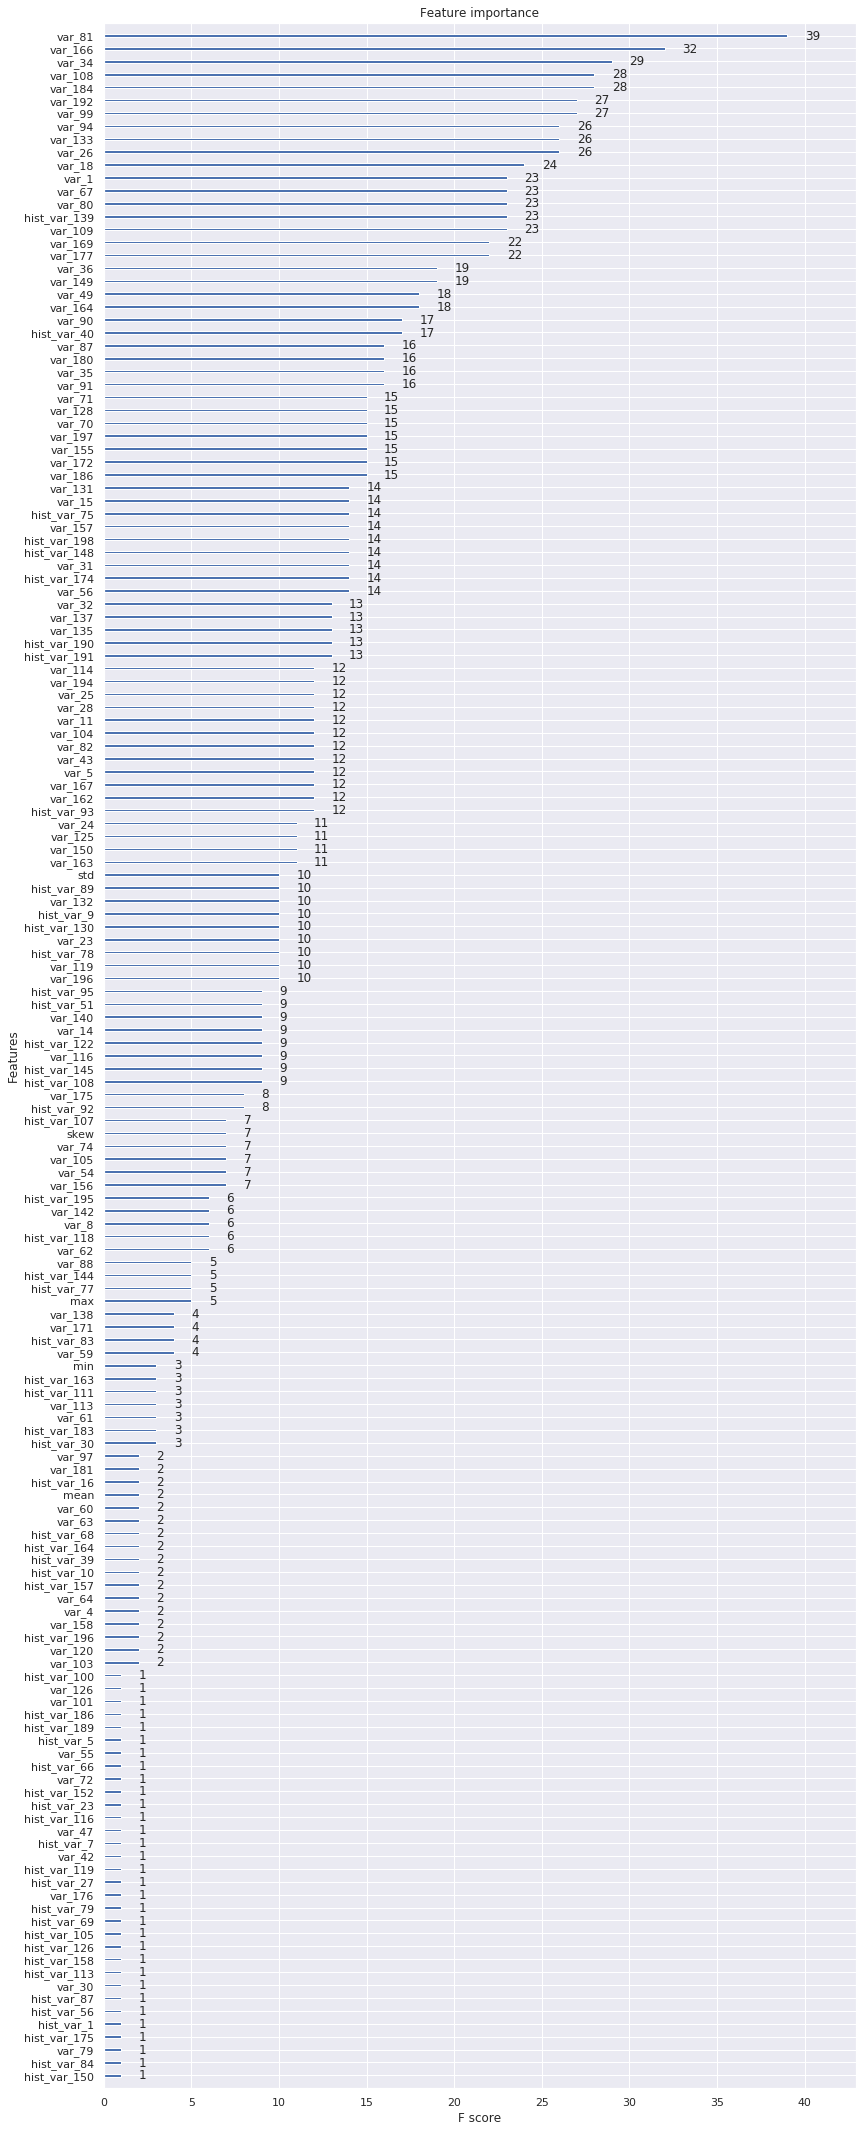

In [36]:
if feature_selection_flag == True:

    num_of_folds = 2 ### must be more than 2

    fs_clf_xgb, predictions_test_fs_xgb = xgboost_all_purpose(X_fs,
                                                              y,
                                                              type_of_training =type_of_training, 
                                                              num_of_folds = num_of_folds, 
                                                              max_early_stopping= 100, 
                                                              name="fs_clf_xgb")
    
    del fs_clf_xgb

#### Test set prediction probabilities distribution after feature selection

In [ ]:
if feature_selection_flag == True:
    sns.set(rc={'figure.figsize':(8,8)})
    plt.hist(predictions_test_fs_xgb)

In [ ]:
if feature_selection_flag == True:
    print(clf_stats_df)

I believe that Feature selection worsen the auc-score, so I will not use it for the future experiments.

### ML Bayesian Optimization Tuning
<a id="Bayes"></a>

In [38]:
if type_of_training == "baseline":
    
    print("baseline")
    from sklearn.model_selection import train_test_split
    xtrain, xvalid, ytrain, yvalid = train_test_split(X, y, stratify = y, random_state=42, test_size=0.3)

elif type_of_training == "oversampling":
    
    print("oversampling")
    
    from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler

    # create a 70/30 split of the data 
    xtrain, xvalid, ytrain, yvalid = train_test_split(X, y, stratify = y, random_state=42, test_size=0.3)

    # RandomOverSampler
    ros = RandomOverSampler(random_state=42)
    X_resampled, y_resampled = ros.fit_resample(xtrain, ytrain)

    from collections import Counter
    print(sorted(Counter(y_resampled).items()))

    xtrain=pd.DataFrame(X_resampled, columns = X.columns)
    ytrain = y_resampled
    del X_resampled
    del y_resampled

    
elif type_of_training == "augmentation_by_fraction":
    
    from sklearn.model_selection import train_test_split
    # the main idea here is to reducing the imbalance ratio from 9:1 to 3:1
    print("augmentation")
    
    from collections import Counter

    # create a 70/30 split of the data 
    xtrain, xvalid, ytrain, yvalid = train_test_split(X, y, stratify = y, random_state=42, test_size=0.3)

    print("ytrain target values count before augmentation:\n", sorted(Counter(ytrain).items()))

    # Augmenting both minority and majority classes via RandomOverSampler by 3 times
    X_y = pd.DataFrame(xtrain, columns=X.columns)
    X_y["target"] = ytrain
    X_y = X_y.sample(frac=3, replace=True)
    X_y.target.value_counts()
    ytrain = X_y['target']
    print("ytrain target values count after oversampling:\n",sorted(Counter(ytrain).items()))
    xtrain = X_y.drop(['target'], axis=1)
    del X_y

    from imblearn.under_sampling import RandomUnderSampler

    # reducing the majority class almost back to its original form
    rus = RandomUnderSampler(sampling_strategy=0.33, random_state=42)
    X_resampled, y_resampled = rus.fit_resample(xtrain, ytrain)

    print("ytrain target values count after Augmentation:\n",sorted(Counter(y_resampled).items()))

    xtrain=pd.DataFrame(X_resampled, columns = X.columns)
    ytrain = y_resampled

    del X_resampled
    del y_resampled
    gc.collect();

augmentation
ytrain target values count before augmentation:
 [(0, 125931), (1, 14069)]
ytrain target values count after oversampling:
 [(0, 377955), (1, 42045)]
ytrain target values count after Augmentation:
 [(0, 127409), (1, 42045)]


In [39]:
from skopt import BayesSearchCV
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb

# Classifier
bayes_cv_tuner = BayesSearchCV(
    estimator = xgb.XGBClassifier(
        nthread = -1,
        objective = 'binary:logistic',
        eval_metric = 'auc',
        silent=1,
        tree_method='auto'
    ),
    search_spaces = {
        'learning_rate': (0.01, 1.0, 'log-uniform'),
        'min_child_weight': (0, 10),
        'n_estimators': (50, 100),
        'max_depth': (0, 10),
        'gamma': (1e-4, 20, 'log-uniform'),
        'subsample': (0.01, 1.0, 'uniform'),
        'colsample_bytree': (0.01, 1.0, 'uniform'),
        'colsample_bylevel': (0.01, 1.0, 'uniform'),
        'reg_lambda': (1e-2, 10, 'log-uniform'),
        'reg_alpha': (1e-4, 1.0, 'log-uniform'),
        'max_delta_step': (0, 20),
        'scale_pos_weight': (1e-1, 10, 'uniform')
    },    
    scoring = 'roc_auc',
    cv = StratifiedKFold(
        n_splits=3,
        shuffle=True,
        random_state=42
    ),
    n_jobs = 1,
    n_iter = 7,   
    verbose = 0,
    refit = True,
    random_state = 42
)

def status_print(optim_result):
    """Status callback durring bayesian hyperparameter search"""
    
    # Get all the models tested so far in DataFrame format
    all_models = pd.DataFrame(bayes_cv_tuner.cv_results_)    
    
    # Get current parameters and the best parameters    
    best_params = pd.Series(bayes_cv_tuner.best_params_)
    print('Model #{}\nBest ROC-AUC: {}\nBest params: {}\n'.format(
        len(all_models),
        np.round(bayes_cv_tuner.best_score_, 4),
        bayes_cv_tuner.best_params_
    ))
    
    ### Save all model results
    #clf_name = bayes_cv_tuner.estimator.__class__.__name__
    #all_models.to_csv(clf_name+"_cv_results.csv")
    ###
    
# Fit the model
result = bayes_cv_tuner.fit(xtrain, ytrain, callback=status_print)

Model #1
Best ROC-AUC: 0.8269
Best params: {'colsample_bylevel': 0.4160029192647807, 'colsample_bytree': 0.7304484857455519, 'gamma': 8.813760476027035, 'learning_rate': 0.042815319280763466, 'max_delta_step': 13, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 87, 'reg_alpha': 0.0016514036651705025, 'reg_lambda': 0.8777579366767239, 'scale_pos_weight': 5.544643023916863, 'subsample': 0.13556548021189216}

Model #2
Best ROC-AUC: 0.8327
Best params: {'colsample_bylevel': 0.8390144719977516, 'colsample_bytree': 0.8844821246070537, 'gamma': 0.004058691981417783, 'learning_rate': 0.7988179462781242, 'max_delta_step': 17, 'max_depth': 1, 'min_child_weight': 1, 'n_estimators': 68, 'reg_alpha': 0.03490731198346208, 'reg_lambda': 7.2517103753896555, 'scale_pos_weight': 6.336020558163781, 'subsample': 0.9923710598637134}

Model #3
Best ROC-AUC: 0.878
Best params: {'colsample_bylevel': 0.4503841871781403, 'colsample_bytree': 0.9195352964526833, 'gamma': 0.00035963466359876904, 'learning_r

In [40]:
gc.collect()

del bayes_cv_tuner
result.best_params_['n_estimators'] = 3000

#params['learning_rate'] = 0.01
#params['scale_pos_weight'] = np.round(y.value_counts()[0] / y.value_counts()[1],3)
#params['max_delta_step'] = 1

result.best_params_

{'colsample_bylevel': 0.8015579071911014,
 'colsample_bytree': 0.44364889457651413,
 'gamma': 0.06189130974499267,
 'learning_rate': 0.2700390206185342,
 'max_delta_step': 18,
 'max_depth': 7,
 'min_child_weight': 4,
 'n_estimators': 3000,
 'reg_alpha': 0.0025842551005350587,
 'reg_lambda': 0.9512149910424356,
 'scale_pos_weight': 5.178580699961442,
 'subsample': 0.8835665823899177}

### Retraining after tuning
<a id="tuned"></a>

In [ ]:
num_of_folds = 4 ### must be more than 2

tuned_clf_xgb, predictions_test_tuned_xgb = xgboost_all_purpose(X,
                                                                y,
                                                                type_of_training = type_of_training, 
                                                                num_of_folds=num_of_folds, 
                                                                params = result.best_params_, 
                                                                max_early_stopping = 400, 
                                                                in_folds_sampling = False,
                                                                name="tuned_clf_xgb")

params {'colsample_bylevel': 0.8015579071911014, 'colsample_bytree': 0.44364889457651413, 'gamma': 0.06189130974499267, 'learning_rate': 0.2700390206185342, 'max_delta_step': 18, 'max_depth': 7, 'min_child_weight': 4, 'n_estimators': 3000, 'reg_alpha': 0.0025842551005350587, 'reg_lambda': 0.9512149910424356, 'scale_pos_weight': 5.178580699961442, 'subsample': 0.8835665823899177}
max_early_stopping: 400
augmentation_by_fraction
ytrain target values count before augmentation:
 [(0, 125931), (1, 14069)]
augmentation before stratification
ytrain target values count after oversampling:
 [(0, 377700), (1, 42300)]
ytrain target values count after Augmentation:
 [(0, 128181), (1, 42300)]

Stratified Fold: 0

[0]	validation_0-auc:0.679499	validation_1-auc:0.662706
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 400 rounds.


#### Test set predictions probabilities without Feature Selection and with Tuning

In [ ]:
sns.set(rc={'figure.figsize':(8,8)})
plt.hist(predictions_test_tuned_xgb)

In [ ]:
clf_stats_df

## ML Blends
** To be updated **

## Preparing for submmission

In [ ]:
if untuned_model_flag == True:
    gc.collect();
    submission = pd.read_csv('../input/sample_submission.csv')
    submission['target'] = predictions_test_xgb
    submission.to_csv('clf_xgb.csv', index=False)


if feature_selection_flag == True:
    gc.collect();
    submission = pd.read_csv('../input/sample_submission.csv')
    submission['target'] = predictions_test_fs_xgb
    submission.to_csv('fs_clf_xgb.csv', index=False)


gc.collect();
submission = pd.read_csv('../input/sample_submission.csv')
submission['target'] = predictions_test_tuned_xgb
submission.to_csv('tuned_clf_xgb.csv', index=False)


## Conclusion
<a id="conclusion"></a>
We can see from EDA and ML Modeling that class #1 is very unbalanced and difficult to identified and classified.